In [1]:
import io
import zipfile
import pandas
import warnings
import os
import yaml
import re
import datetime
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

min_epoch = int(datetime.datetime.timestamp(datetime.datetime(2019, 7, 4)))
max_epoch = int(datetime.datetime.timestamp(datetime.datetime(2019, 7, 5)))

df = pandas.read_hdf('../../../g5k_data/data.db', where=['cluster = dahu', 'start_time > %d' % min_epoch, 'start_time < %d' % max_epoch])
print('Missing nodes: %s' % (set(range(1, 33)) - set(df.node.unique())))
df['cpu'] = df['node']*2 + df['cpu']
df['mnk'] = df.m * df.n * df.k
df['mn'] = df.m * df.n
df['mk'] = df.m * df.k
df['nk'] = df.n * df.k
df.head()

Missing nodes: set()


,function,m,n,k,timestamp,duration,core,node,cluster,jobid,cpu,start_time,index,mnk,mn,mk,nk
0,dgemm,6081,10182,140,199.910209,0.573353,0,1,dahu,1872787,2,1562253701,0,8668343880,61916742,851340,1425480
1,dgemm,5658,1052,1288,200.483587,0.529990,0,1,dahu,1872787,2,1562253701,1,7666454208,5952216,7287504,1354976
2,dgemm,1139,4602,827,201.013586,0.304688,0,1,dahu,1872787,2,1562253701,2,4334867706,5241678,941953,3805854
3,dgemm,1343,1248,1991,201.318281,0.234120,0,1,dahu,1872787,2,1562253701,3,3337043424,1676064,2673913,2484768
4,dgemm,2466,975,1247,201.552409,0.209882,0,1,dahu,1872787,2,1562253701,4,2998224450,2404350,3075102,1215825


In [2]:
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)

/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


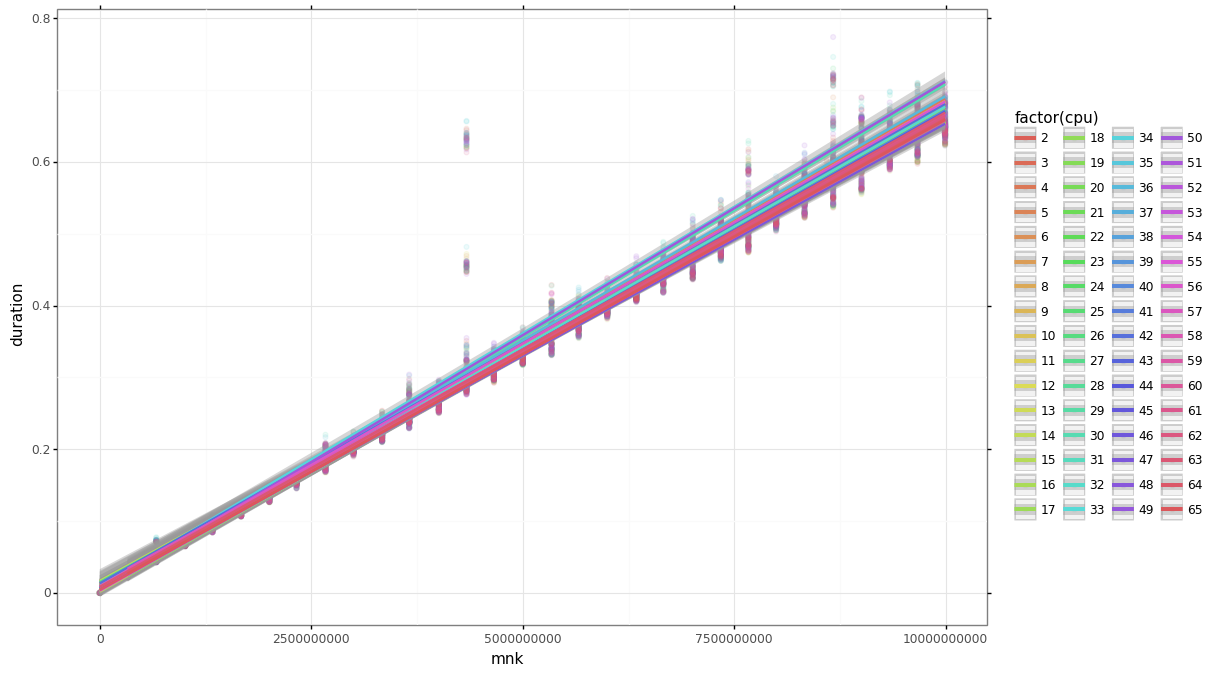

<ggplot: (-9223363288697614087)>

In [3]:
tmp = df[df.mnk < 2e10]
ggplot(tmp.sample(n=10000), aes(x='mnk', y='duration', color='factor(cpu)'))  + geom_point(alpha=0.1) + geom_smooth(method='lm') + theme_bw()

/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


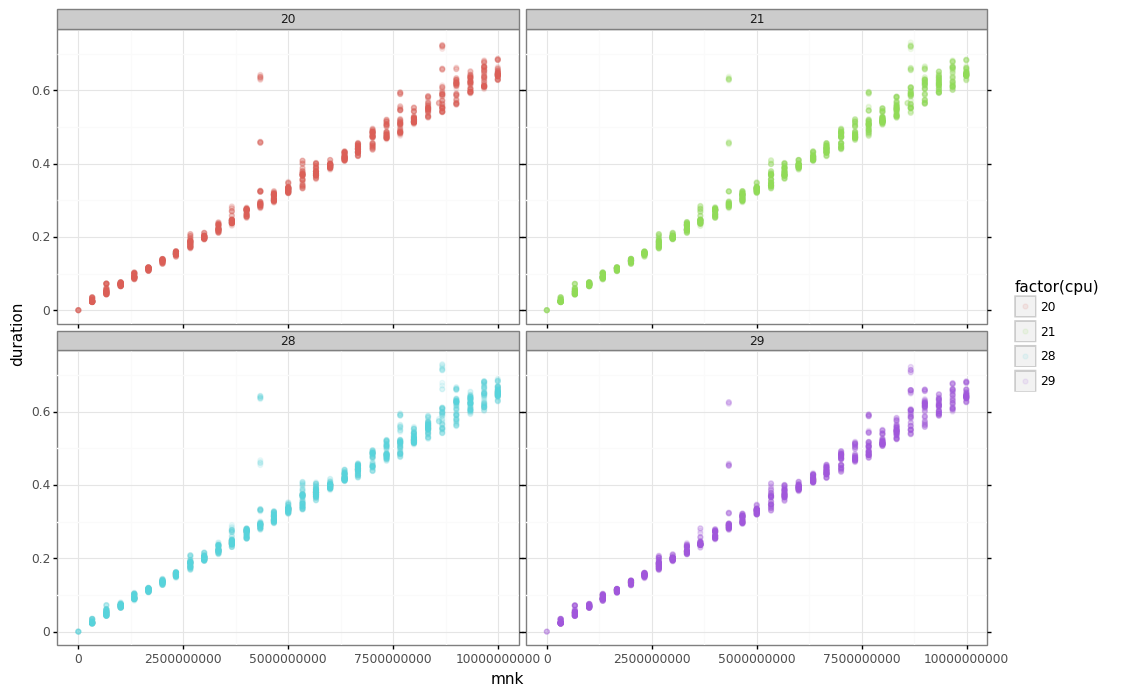

<ggplot: (-9223363288751474793)>

In [4]:
ggplot(tmp[tmp.node.isin([10, 14])].sample(n=10000), aes(x='mnk', y='duration', color='factor(cpu)')) + facet_wrap('cpu') + geom_point(alpha=0.1) + theme_bw()

## Classical regression

We fix the intercept by hand, otherwise it gets too high.

In [5]:
from statsmodels.formula.api import ols
import numpy

def compute_intercept(df, x, y):
    short_calls = df[df[x] <= df[x].min() * 100]  # taking the calls smallet than 100 times the smallest one
    short_calls = short_calls[short_calls[y] < short_calls[y].quantile(0.95)]  # removing the 5% longest calls, we have very large outliers (without this, the intercept is 3 times larger)
    return short_calls[y].mean()

def compute_reg(df, y_var, x_vars, aggregate=False, verbose=False):
    assert 'mnk' in x_vars
    model = '%s ~ %s + 0' % (y_var, ' + '.join(x_vars))
    if verbose:
        print(model)
    df = df.copy()
    if aggregate:
        if aggregate == 'mean':
            df = df.groupby(x_vars)[[y_var]].mean().reset_index()
        elif aggregate == 'std':
            df = df.groupby(x_vars)[[y_var]].std().reset_index()
        else:
            assert False
    intercept = max(0, compute_intercept(df, 'mnk', y_var))
    df[y_var] -= intercept
    reg = ols(formula=model, data=df).fit()
    if verbose:
        print(df.head())
        print(reg.summary())
    return {'intercept': intercept, **{var: reg.params[var] for var in x_vars}}

def predict(df, reg, variables):
    pred = numpy.zeros(len(df))
    pred += reg['intercept']
    for var in variables:
        pred += reg[var] * df[var]
    return pred

def compute_full_reg(df, variables, draw_plot=False, verbose=False):
    df = df.copy()
    reg_duration = compute_reg(df, 'duration', variables, aggregate='mean', verbose=verbose)
    df['pred'] = predict(df, reg_duration, variables)
    df['residual'] = df['duration'] - df['pred']
    reg_residual = compute_reg(df, 'residual', variables, aggregate='std', verbose=verbose)
    for k, v in reg_residual.items():
        reg_duration['%s_residual' % k] = reg_residual[k]
    if draw_plot:
        df['sd_noise'] = predict(df, reg_residual, variables)
        df['sigma'] = df['sd_noise']/numpy.sqrt(1-2/numpy.pi)
        df['mu'] = -df['sigma']*numpy.sqrt(2/numpy.pi)
        df['noise'] = numpy.abs(numpy.random.normal(0, 1, len(df)))
        df['noise'] *= df['sigma']
        df['noise'] += df['mu']
        df['pred_noise'] = df['pred'] + df['noise']
        plot = ggplot(df.sample(n=10000), aes(x='mnk')) + geom_point(aes(y='duration'), alpha=0.5) + theme_bw()
        plot1 = plot + geom_point(aes(y='pred'), color='orange', alpha=0.5) + ggtitle('Predictions without noise')
        print(plot1)
        print(plot1 + scale_x_log10() + scale_y_log10())
        plot2 = plot + geom_point(aes(y='pred_noise'), color='lime', alpha=0.5) + ggtitle('Predictions with noise')
        print(plot2)
        print(plot2 + scale_x_log10() + scale_y_log10())
    return reg_duration

duration ~ mnk + mn + mk + nk + 0
         mnk      mn       mk       nk      duration
0          1       1        1        1  0.000000e+00
1         64      16       16       16  2.305869e-07
2  329334390  145530   712845  1045506  2.507532e-02
3  329334390  145530  1045506   712845  2.502487e-02
4  329334390  712845   145530  1045506  2.368844e-02
                                 OLS Regression Results                                
Dep. Variable:               duration   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          6.567e+05
Date:                Sat, 13 Jul 2019   Prob (F-statistic):                        0.00
Time:                        13:09:06   Log-Likelihood:                          2034.1
No. Observations:                 543   AIC:                                     -4060.
Df Residuals:                   

/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


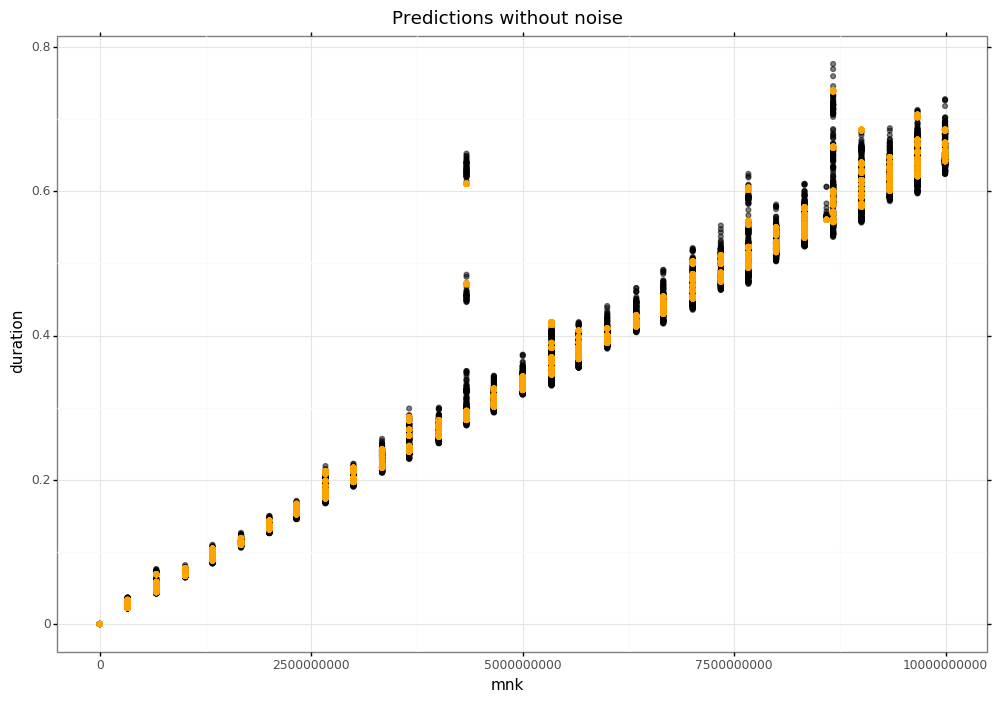

<ggplot: (8748102035057)>


/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


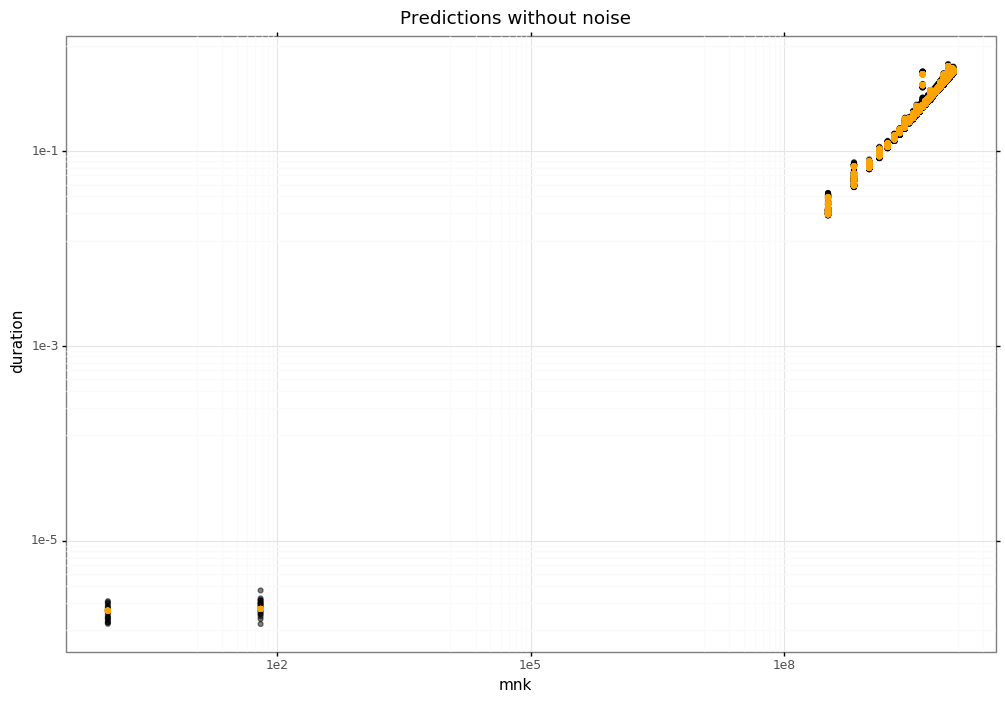

<ggplot: (8748101942550)>


/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


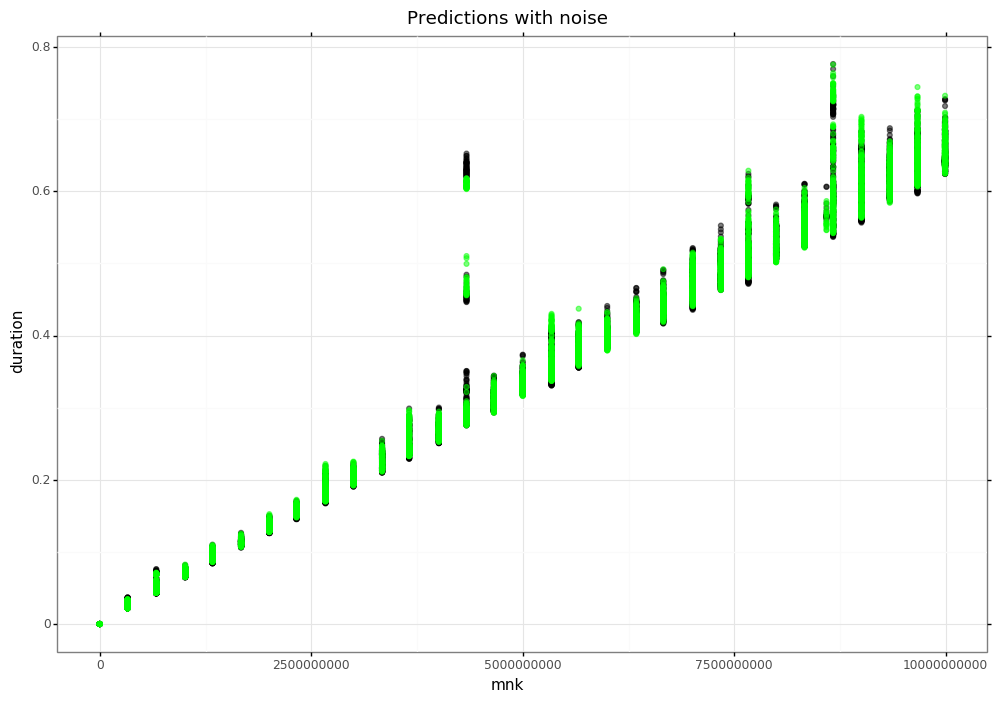

<ggplot: (-9223363288777745362)>


/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


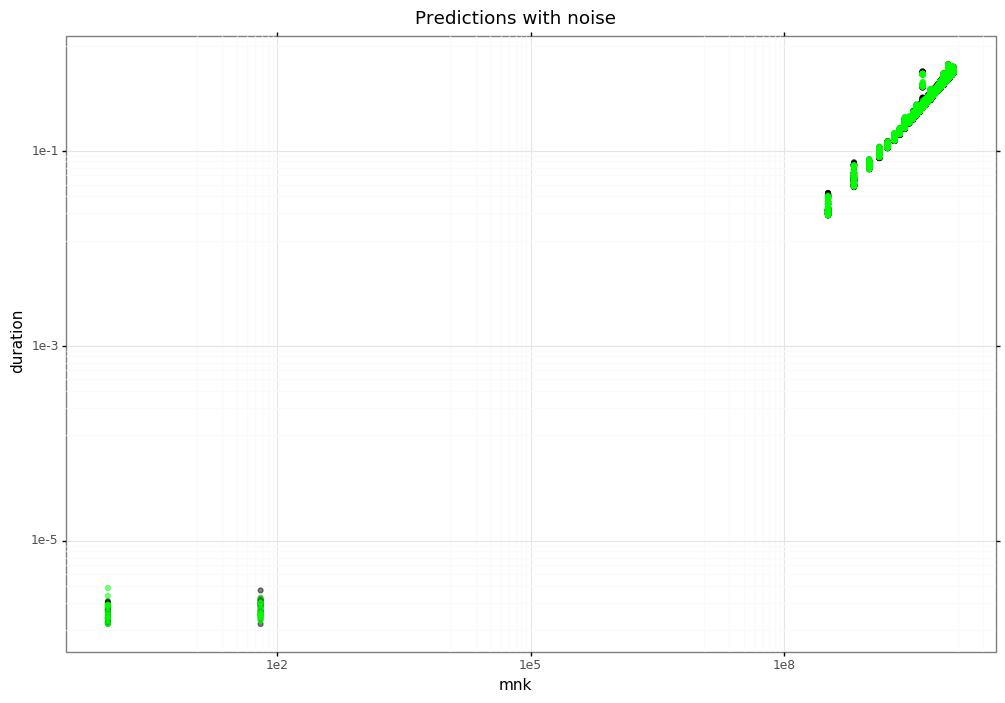

<ggplot: (8748076834154)>
CPU times: user 7.64 s, sys: 1.22 s, total: 8.86 s
Wall time: 7.28 s


{'intercept': 1.9026542968749986e-06,
 'mnk': 6.275190429417372e-11,
 'mn': 1.849726315796586e-10,
 'mk': 1.8300982737502207e-09,
 'nk': 3.1137528384031938e-09,
 'intercept_residual': 3.9781880570324614e-07,
 'mnk_residual': 1.3223504617143143e-12,
 'mn_residual': 5.070484275518588e-12,
 'mk_residual': 6.161167574031251e-11,
 'nk_residual': -2.4515590177532285e-12}

In [6]:
%time reg_global = compute_full_reg(df, ['mnk', 'mn', 'mk', 'nk'], draw_plot=True, verbose=True)
reg_global

## Linear model

In [7]:
def compute_reg_percpu(df, variables):
    reg_local = []
    for cpu in sorted(df['cpu'].unique()):
        tmp = df[df['cpu'] == cpu] 
        reg = compute_full_reg(tmp, variables)
        reg['node'] = tmp['node'].unique()[0]
        reg['cpu'] = cpu
        reg_local.append(reg)
    return reg_local

reg_local = compute_reg_percpu(df, ['mnk'])
reg_local_pandas = pandas.DataFrame(reg_local).drop(['node', 'cpu'], 1)
reg_local_pandas.describe()

,intercept,intercept_residual,mnk,mnk_residual
count,6.400000e+01,6.400000e+01,6.400000e+01,6.400000e+01
mean,1.901050e-06,3.266040e-07,6.726232e-11,2.187295e-12
std,9.657716e-08,7.844932e-08,1.345387e-12,5.470926e-14
min,1.699313e-06,1.735386e-07,6.611237e-11,2.093713e-12
25%,1.837172e-06,2.731028e-07,6.646291e-11,2.137635e-12
50%,1.888437e-06,3.101403e-07,6.671941e-11,2.181383e-12
75%,1.962109e-06,3.678842e-07,6.730635e-11,2.225045e-12
max,2.156563e-06,6.198059e-07,7.152593e-11,2.303675e-12


In [8]:
def compute_mean_reg(reg):
    mean_reg = {}
    reg = pandas.DataFrame(reg)
    for var in reg.columns:
        if var in ['node', 'cpu']:
            continue
        mean_reg[var] = reg[var].mean()
    return mean_reg

compute_mean_reg(reg_local)

{'intercept': 1.9010498046875001e-06,
 'intercept_residual': 3.266039542205622e-07,
 'mnk': 6.726232478300256e-11,
 'mnk_residual': 2.1872945766000463e-12}

In [9]:
def get_reg(reg, residual):
    if residual:
        reg = {k[:-9]: v for k, v in reg.items() if k.endswith('_residual')}
    else:
        reg = {k: v for k, v in reg.items() if not k.endswith('_residual')}
    return reg
    
def model_str(reg, residual=False):
    reg = get_reg(reg, residual)
    parameters = []
    for name, param in reg.items():
        if param == 0:
            continue
        if name != 'intercept':
            parameters.append('%e*%s' % (param, name))
        else:
            parameters.append('%e' % reg[name])
    return ' + '.join(parameters)

def __return_stmt(reg):
    mu    = model_str(reg, False)
    sigma = model_str(reg, True)
    result  = '        mu    = %s;\n' % mu
    result += '        sigma = %s;\n' % sigma
    result += '        return mu + random_halfnormal_shifted(0, sigma);'
    return result

def __reg_to_c(reg):
    tmp = dict(reg)
    del tmp['cpu']
    del tmp['node']
    return '''    case %d: // node %d\n%s''' % (reg['cpu'], reg['node'], __return_stmt(tmp))

def reg_to_c(all_reg):
    result = [__reg_to_c(reg) for reg in all_reg]
    return '\n'.join(result)

def dump_reg(all_reg):
    reg_code = reg_to_c(all_reg)
    reg_code_default = __return_stmt(compute_mean_reg(all_reg))
    reg_code = 'double mu, sigma;\nswitch(get_cpuid()) {\n%s\n    default:\n%s\n}' % (reg_code, reg_code_default)
    from IPython.display import Markdown, display
    display(Markdown('```c\n%s\n```' % reg_code))

dump_reg(reg_local)

```c
double mu, sigma;
switch(get_cpuid()) {
    case 2: // node 1
        mu    = 2.031875e-06 + 7.106020e-11*mnk;
        sigma = 3.568280e-07 + 2.255177e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 3: // node 1
        mu    = 1.823625e-06 + 6.681268e-11*mnk;
        sigma = 2.867134e-07 + 2.216412e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 4: // node 2
        mu    = 1.793563e-06 + 6.959327e-11*mnk;
        sigma = 2.294533e-07 + 2.303675e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 5: // node 2
        mu    = 2.039063e-06 + 6.672233e-11*mnk;
        sigma = 4.459159e-07 + 2.221241e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 6: // node 3
        mu    = 1.959375e-06 + 6.856235e-11*mnk;
        sigma = 2.402006e-07 + 2.302876e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 7: // node 3
        mu    = 1.847375e-06 + 6.657797e-11*mnk;
        sigma = 3.594620e-07 + 2.162996e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 8: // node 4
        mu    = 1.998187e-06 + 6.670744e-11*mnk;
        sigma = 3.049520e-07 + 2.176511e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 9: // node 4
        mu    = 1.817000e-06 + 6.676213e-11*mnk;
        sigma = 3.134492e-07 + 2.169773e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 10: // node 5
        mu    = 1.820687e-06 + 6.900958e-11*mnk;
        sigma = 2.678372e-07 + 2.272454e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 11: // node 5
        mu    = 1.947375e-06 + 6.634334e-11*mnk;
        sigma = 3.068313e-07 + 2.106975e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 12: // node 6
        mu    = 1.713125e-06 + 6.898347e-11*mnk;
        sigma = 3.035692e-07 + 2.268374e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 13: // node 6
        mu    = 1.699313e-06 + 6.611237e-11*mnk;
        sigma = 3.698865e-07 + 2.116270e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 14: // node 7
        mu    = 1.886312e-06 + 6.670143e-11*mnk;
        sigma = 2.518608e-07 + 2.196110e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 15: // node 7
        mu    = 1.796812e-06 + 6.620022e-11*mnk;
        sigma = 3.626939e-07 + 2.093713e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 16: // node 8
        mu    = 1.804438e-06 + 6.766008e-11*mnk;
        sigma = 2.663016e-07 + 2.218218e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 17: // node 8
        mu    = 1.838500e-06 + 6.645103e-11*mnk;
        sigma = 2.998226e-07 + 2.149576e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 18: // node 9
        mu    = 1.917312e-06 + 6.660817e-11*mnk;
        sigma = 3.490054e-07 + 2.129302e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 19: // node 9
        mu    = 1.847000e-06 + 6.645524e-11*mnk;
        sigma = 3.180082e-07 + 2.125127e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 20: // node 10
        mu    = 1.761937e-06 + 6.677718e-11*mnk;
        sigma = 2.238800e-07 + 2.192597e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 21: // node 10
        mu    = 1.922875e-06 + 6.677056e-11*mnk;
        sigma = 3.366890e-07 + 2.184108e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 22: // node 11
        mu    = 1.861937e-06 + 6.637786e-11*mnk;
        sigma = 4.185254e-07 + 2.133917e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 23: // node 11
        mu    = 2.156563e-06 + 6.767677e-11*mnk;
        sigma = 4.030012e-07 + 2.267427e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 24: // node 12
        mu    = 2.022250e-06 + 6.664942e-11*mnk;
        sigma = 2.922302e-07 + 2.168919e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 25: // node 12
        mu    = 1.895062e-06 + 6.637904e-11*mnk;
        sigma = 3.338113e-07 + 2.146275e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 26: // node 13
        mu    = 1.946938e-06 + 6.728306e-11*mnk;
        sigma = 2.636078e-07 + 2.233698e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 27: // node 13
        mu    = 1.915750e-06 + 6.655917e-11*mnk;
        sigma = 4.160324e-07 + 2.137918e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 28: // node 14
        mu    = 1.888000e-06 + 6.737625e-11*mnk;
        sigma = 3.060832e-07 + 2.254562e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 29: // node 14
        mu    = 1.876250e-06 + 6.656043e-11*mnk;
        sigma = 4.447404e-07 + 2.165384e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 30: // node 15
        mu    = 2.027313e-06 + 7.122081e-11*mnk;
        sigma = 3.439558e-07 + 2.271207e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 31: // node 15
        mu    = 1.897313e-06 + 6.645221e-11*mnk;
        sigma = 3.715223e-07 + 2.136785e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 32: // node 16
        mu    = 1.805000e-06 + 6.859906e-11*mnk;
        sigma = 1.983260e-07 + 2.248535e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 33: // node 16
        mu    = 2.061687e-06 + 6.665753e-11*mnk;
        sigma = 3.943524e-07 + 2.156724e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 34: // node 17
        mu    = 1.927125e-06 + 7.105423e-11*mnk;
        sigma = 2.357691e-07 + 2.258386e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 35: // node 17
        mu    = 1.840500e-06 + 6.678021e-11*mnk;
        sigma = 2.561754e-07 + 2.210687e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 36: // node 18
        mu    = 2.027813e-06 + 7.034603e-11*mnk;
        sigma = 3.002064e-07 + 2.242578e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 37: // node 18
        mu    = 1.824375e-06 + 6.645969e-11*mnk;
        sigma = 3.967755e-07 + 2.114498e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 38: // node 19
        mu    = 1.970375e-06 + 6.698452e-11*mnk;
        sigma = 2.644972e-07 + 2.228034e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 39: // node 19
        mu    = 2.141750e-06 + 6.654623e-11*mnk;
        sigma = 5.203626e-07 + 2.156175e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 40: // node 20
        mu    = 1.865688e-06 + 6.741311e-11*mnk;
        sigma = 2.772743e-07 + 2.224048e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 41: // node 20
        mu    = 1.844062e-06 + 6.651395e-11*mnk;
        sigma = 3.830493e-07 + 2.157152e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 42: // node 21
        mu    = 1.899687e-06 + 6.827516e-11*mnk;
        sigma = 2.948335e-07 + 2.278441e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 43: // node 21
        mu    = 1.940625e-06 + 6.671650e-11*mnk;
        sigma = 1.735386e-07 + 2.182037e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 44: // node 22
        mu    = 1.919000e-06 + 6.683427e-11*mnk;
        sigma = 2.798954e-07 + 2.202200e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 45: // node 22
        mu    = 1.875250e-06 + 6.703196e-11*mnk;
        sigma = 2.939988e-07 + 2.178362e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 46: // node 23
        mu    = 1.888875e-06 + 6.682287e-11*mnk;
        sigma = 3.385195e-07 + 2.195844e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 47: // node 23
        mu    = 1.901437e-06 + 6.620405e-11*mnk;
        sigma = 3.148678e-07 + 2.105850e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 48: // node 24
        mu    = 1.881375e-06 + 6.683722e-11*mnk;
        sigma = 2.714981e-07 + 2.191642e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 49: // node 24
        mu    = 2.094625e-06 + 6.642552e-11*mnk;
        sigma = 6.198059e-07 + 2.129534e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 50: // node 25
        mu    = 2.032188e-06 + 7.152593e-11*mnk;
        sigma = 3.254480e-07 + 2.262841e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 51: // node 25
        mu    = 1.833188e-06 + 6.615333e-11*mnk;
        sigma = 3.375893e-07 + 2.123278e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 52: // node 26
        mu    = 1.880250e-06 + 6.663195e-11*mnk;
        sigma = 2.736377e-07 + 2.154669e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 53: // node 26
        mu    = 1.970313e-06 + 6.707467e-11*mnk;
        sigma = 4.829437e-07 + 2.220125e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 54: // node 27
        mu    = 1.980687e-06 + 6.689868e-11*mnk;
        sigma = 2.983720e-07 + 2.205206e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 55: // node 27
        mu    = 1.974188e-06 + 6.701777e-11*mnk;
        sigma = 2.836010e-07 + 2.213369e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 56: // node 28
        mu    = 1.977875e-06 + 6.885807e-11*mnk;
        sigma = 2.558424e-07 + 2.255494e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 57: // node 28
        mu    = 1.857938e-06 + 6.646399e-11*mnk;
        sigma = 3.404247e-07 + 2.136342e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 58: // node 29
        mu    = 1.896375e-06 + 6.667642e-11*mnk;
        sigma = 2.431139e-07 + 2.180729e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 59: // node 29
        mu    = 1.762000e-06 + 6.664905e-11*mnk;
        sigma = 2.861419e-07 + 2.147675e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 60: // node 30
        mu    = 1.794250e-06 + 6.643714e-11*mnk;
        sigma = 3.752261e-07 + 2.135387e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 61: // node 30
        mu    = 1.848187e-06 + 6.629171e-11*mnk;
        sigma = 4.537737e-07 + 2.131886e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 62: // node 31
        mu    = 1.764000e-06 + 6.672833e-11*mnk;
        sigma = 2.465163e-07 + 2.153920e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 63: // node 31
        mu    = 1.943188e-06 + 6.669010e-11*mnk;
        sigma = 3.981035e-07 + 2.183505e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 64: // node 32
        mu    = 1.809313e-06 + 6.641775e-11*mnk;
        sigma = 3.340864e-07 + 2.134676e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 65: // node 32
        mu    = 1.880875e-06 + 6.636575e-11*mnk;
        sigma = 3.672168e-07 + 2.109447e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    default:
        mu    = 1.901050e-06 + 6.726232e-11*mnk;
        sigma = 3.266040e-07 + 2.187295e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
}
```

## Polynomial model

In [10]:
reg_local_poly = compute_reg_percpu(df, ['mnk', 'mn', 'mk', 'nk'])
reg_local_poly_pandas = pandas.DataFrame(reg_local_poly).drop(['node', 'cpu'], 1)
reg_local_poly_pandas.describe()

,intercept,intercept_residual,mk,mk_residual,mn,mn_residual,mnk,mnk_residual,nk,nk_residual
count,6.400000e+01,6.400000e+01,6.400000e+01,6.400000e+01,6.400000e+01,6.400000e+01,6.400000e+01,6.400000e+01,6.400000e+01,6.400000e+01
mean,1.901050e-06,3.266040e-07,1.830098e-09,2.553385e-11,1.849726e-10,4.807115e-12,6.275190e-11,1.903062e-13,3.113753e-09,2.725599e-11
std,9.657716e-08,7.844932e-08,6.401597e-11,6.089523e-12,6.549260e-12,4.034511e-12,1.303008e-12,1.262517e-13,4.270179e-11,1.226949e-11
min,1.699313e-06,1.735386e-07,1.720842e-09,9.921222e-12,1.694949e-10,-3.574783e-12,6.167847e-11,7.634906e-14,3.001103e-09,-1.092789e-12
25%,1.837172e-06,2.731028e-07,1.780777e-09,2.173071e-11,1.817356e-10,2.260318e-12,6.202612e-11,1.054119e-13,3.081931e-09,2.346001e-11
50%,1.888437e-06,3.101403e-07,1.815672e-09,2.542395e-11,1.842232e-10,4.444155e-12,6.219685e-11,1.219784e-13,3.116022e-09,2.734979e-11
75%,1.962109e-06,3.678842e-07,1.868974e-09,2.990134e-11,1.878267e-10,6.875068e-12,6.271806e-11,2.776635e-13,3.144691e-09,3.218459e-11
max,2.156563e-06,6.198059e-07,1.960147e-09,3.975663e-11,2.129481e-10,2.123358e-11,6.687468e-11,5.340431e-13,3.190992e-09,5.946323e-11


In [11]:
dump_reg(reg_local_poly)

```c
double mu, sigma;
switch(get_cpuid()) {
    case 2: // node 1
        mu    = 2.031875e-06 + 6.647348e-11*mnk + 1.894452e-10*mn + 1.957824e-09*mk + 3.059798e-09*nk;
        sigma = 3.568280e-07 + 3.758137e-13*mnk + 3.490725e-12*mn + 1.151553e-11*mk + 5.660122e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 3: // node 1
        mu    = 1.823625e-06 + 6.224824e-11*mnk + 1.793597e-10*mn + 1.830960e-09*mk + 3.183051e-09*nk;
        sigma = 2.867134e-07 + 1.203120e-13*mnk + 5.485074e-12*mn + 3.488718e-11*mk + 3.129052e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 4: // node 2
        mu    = 1.793563e-06 + 6.507976e-11*mnk + 1.774582e-10*mn + 1.938141e-09*mk + 3.001103e-09*nk;
        sigma = 2.294533e-07 + 5.340431e-13*mnk + -1.058776e-12*mn + 1.914962e-11*mk + 4.256655e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 5: // node 2
        mu    = 2.039063e-06 + 6.215652e-11*mnk + 1.835837e-10*mn + 1.821377e-09*mk + 3.190992e-09*nk;
        sigma = 4.459159e-07 + 9.818183e-14*mnk + 1.579534e-11*mn + 2.760985e-11*mk + 3.029784e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 6: // node 3
        mu    = 1.959375e-06 + 6.398854e-11*mnk + 1.764182e-10*mn + 1.916735e-09*mk + 3.100890e-09*nk;
        sigma = 2.402006e-07 + 4.558944e-13*mnk + 1.217797e-12*mn + 1.612409e-11*mk + 1.541685e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 7: // node 3
        mu    = 1.847375e-06 + 6.209200e-11*mnk + 1.764626e-10*mn + 1.797731e-09*mk + 3.131726e-09*nk;
        sigma = 3.594620e-07 + 1.144761e-13*mnk + 1.555055e-12*mn + 2.090426e-11*mk + 2.464432e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 8: // node 4
        mu    = 1.998187e-06 + 6.219294e-11*mnk + 1.824372e-10*mn + 1.811525e-09*mk + 3.143610e-09*nk;
        sigma = 3.049520e-07 + 1.209021e-13*mnk + 8.917642e-12*mn + 2.398301e-11*mk + 2.528166e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 9: // node 4
        mu    = 1.817000e-06 + 6.226075e-11*mnk + 1.785609e-10*mn + 1.806540e-09*mk + 3.135141e-09*nk;
        sigma = 3.134492e-07 + 1.189552e-13*mnk + 8.829644e-13*mn + 2.808735e-11*mk + 2.638956e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 10: // node 5
        mu    = 1.820687e-06 + 6.441624e-11*mnk + 1.894869e-10*mn + 1.946019e-09*mk + 3.075501e-09*nk;
        sigma = 2.678372e-07 + 4.037501e-13*mnk + 4.570862e-12*mn + 3.233506e-11*mk + 3.230984e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 11: // node 5
        mu    = 1.947375e-06 + 6.194686e-11*mnk + 1.862013e-10*mn + 1.756690e-09*mk + 3.062519e-09*nk;
        sigma = 3.068313e-07 + 1.242464e-13*mnk + 4.195734e-12*mn + 2.529380e-11*mk + 2.894407e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 12: // node 6
        mu    = 1.713125e-06 + 6.444369e-11*mnk + 1.828127e-10*mn + 1.940450e-09*mk + 3.026592e-09*nk;
        sigma = 3.035692e-07 + 4.329853e-13*mnk + 3.441705e-12*mn + 1.852717e-11*mk + 3.062344e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 13: // node 6
        mu    = 1.699313e-06 + 6.167847e-11*mnk + 1.880559e-10*mn + 1.742905e-09*mk + 3.115455e-09*nk;
        sigma = 3.698865e-07 + 7.634906e-14*mnk + 1.889689e-12*mn + 2.289241e-11*mk + 2.447070e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 14: // node 7
        mu    = 1.886312e-06 + 6.213976e-11*mnk + 1.800674e-10*mn + 1.832612e-09*mk + 3.179120e-09*nk;
        sigma = 2.518608e-07 + 9.756533e-14*mnk + 3.179885e-12*mn + 2.565463e-11*mk + 3.214284e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 15: // node 7
        mu    = 1.796812e-06 + 6.182462e-11*mnk + 1.856477e-10*mn + 1.720842e-09*mk + 3.073904e-09*nk;
        sigma = 3.626939e-07 + 1.050499e-13*mnk + 2.203707e-12*mn + 1.879176e-11*mk + 2.035166e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 16: // node 8
        mu    = 1.804438e-06 + 6.310574e-11*mnk + 2.018187e-10*mn + 1.868968e-09*mk + 3.090713e-09*nk;
        sigma = 2.663016e-07 + 3.681589e-13*mnk + 6.523818e-12*mn + 2.301578e-11*mk + 3.021082e-12*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 17: // node 8
        mu    = 1.838500e-06 + 6.197113e-11*mnk + 1.848484e-10*mn + 1.782762e-09*mk + 3.130368e-09*nk;
        sigma = 2.998226e-07 + 1.055326e-13*mnk + 4.468914e-12*mn + 2.228399e-11*mk + 2.692329e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 18: // node 9
        mu    = 1.917312e-06 + 6.215594e-11*mnk + 1.846905e-10*mn + 1.788500e-09*mk + 3.091349e-09*nk;
        sigma = 3.490054e-07 + 1.045883e-13*mnk + 2.405213e-12*mn + 2.555409e-11*mk + 3.335459e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 19: // node 9
        mu    = 1.847000e-06 + 6.202462e-11*mnk + 1.829354e-10*mn + 1.775471e-09*mk + 3.084816e-09*nk;
        sigma = 3.180082e-07 + 1.085927e-13*mnk + 2.728627e-12*mn + 1.914810e-11*mk + 2.859961e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 20: // node 10
        mu    = 1.761937e-06 + 6.222181e-11*mnk + 1.855436e-10*mn + 1.821154e-09*mk + 3.179540e-09*nk;
        sigma = 2.238800e-07 + 9.975338e-14*mnk + 8.993402e-12*mn + 2.347787e-11*mk + 2.859278e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 21: // node 10
        mu    = 1.922875e-06 + 6.224746e-11*mnk + 1.770054e-10*mn + 1.813126e-09*mk + 3.159407e-09*nk;
        sigma = 3.366890e-07 + 1.042956e-13*mnk + 4.338806e-12*mn + 2.668150e-11*mk + 3.678854e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 22: // node 11
        mu    = 1.861937e-06 + 6.193978e-11*mnk + 1.815856e-10*mn + 1.771325e-09*mk + 3.098444e-09*nk;
        sigma = 4.185254e-07 + 1.112563e-13*mnk + 1.537229e-12*mn + 2.329886e-11*mk + 2.229895e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 23: // node 11
        mu    = 2.156563e-06 + 6.312184e-11*mnk + 1.694949e-10*mn + 1.898300e-09*mk + 3.101271e-09*nk;
        sigma = 4.030012e-07 + 3.606249e-13*mnk + 5.396304e-13*mn + 3.475840e-11*mk + 8.167141e-12*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 24: // node 12
        mu    = 2.022250e-06 + 6.214578e-11*mnk + 1.857814e-10*mn + 1.800993e-09*mk + 3.138911e-09*nk;
        sigma = 2.922302e-07 + 1.060908e-13*mnk + 8.117540e-12*mn + 2.387615e-11*mk + 2.887370e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 25: // node 12
        mu    = 1.895062e-06 + 6.193387e-11*mnk + 1.785727e-10*mn + 1.761633e-09*mk + 3.116495e-09*nk;
        sigma = 3.338113e-07 + 1.247276e-13*mnk + 4.419396e-12*mn + 2.463158e-11*mk + 2.695258e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 26: // node 13
        mu    = 1.946938e-06 + 6.268952e-11*mnk + 1.877887e-10*mn + 1.868990e-09*mk + 3.163174e-09*nk;
        sigma = 2.636078e-07 + 2.662698e-13*mnk + 6.017135e-12*mn + 3.442548e-11*mk + 6.810535e-12*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 27: // node 13
        mu    = 1.915750e-06 + 6.207186e-11*mnk + 1.910115e-10*mn + 1.802216e-09*mk + 3.116125e-09*nk;
        sigma = 4.160324e-07 + 7.942737e-14*mnk + 6.492119e-12*mn + 2.946518e-11*mk + 3.494893e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 28: // node 14
        mu    = 1.888000e-06 + 6.280369e-11*mnk + 1.864690e-10*mn + 1.875896e-09*mk + 3.131536e-09*nk;
        sigma = 3.060832e-07 + 3.301377e-13*mnk + 3.680653e-12*mn + 2.101870e-11*mk + -1.092789e-12*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 29: // node 14
        mu    = 1.876250e-06 + 6.206682e-11*mnk + 1.820832e-10*mn + 1.808254e-09*mk + 3.121687e-09*nk;
        sigma = 4.447404e-07 + 1.086659e-13*mnk + 3.545912e-12*mn + 3.104860e-11*mk + 2.832664e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 30: // node 15
        mu    = 2.027313e-06 + 6.656926e-11*mnk + 1.922304e-10*mn + 1.948290e-09*mk + 3.141456e-09*nk;
        sigma = 3.439558e-07 + 3.118445e-13*mnk + -5.454007e-13*mn + 2.034084e-11*mk + 5.456848e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 31: // node 15
        mu    = 1.897313e-06 + 6.199347e-11*mnk + 1.843830e-10*mn + 1.780865e-09*mk + 3.107970e-09*nk;
        sigma = 3.715223e-07 + 1.146332e-13*mnk + 2.746758e-12*mn + 3.419336e-11*mk + 2.789535e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 32: // node 16
        mu    = 1.805000e-06 + 6.405832e-11*mnk + 1.963515e-10*mn + 1.902175e-09*mk + 3.055625e-09*nk;
        sigma = 1.983260e-07 + 4.474823e-13*mnk + -1.877178e-13*mn + 1.898083e-11*mk + 2.763580e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 33: // node 16
        mu    = 2.061687e-06 + 6.216529e-11*mnk + 1.845531e-10*mn + 1.828339e-09*mk + 3.097299e-09*nk;
        sigma = 3.943524e-07 + 1.344542e-13*mnk + 1.423471e-12*mn + 3.001454e-11*mk + 2.359264e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 34: // node 17
        mu    = 1.927125e-06 + 6.646319e-11*mnk + 1.856543e-10*mn + 1.951536e-09*mk + 3.074791e-09*nk;
        sigma = 2.357691e-07 + 3.549577e-13*mnk + -1.695110e-12*mn + 9.921222e-12*mk + 5.907562e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 35: // node 17
        mu    = 1.840500e-06 + 6.220517e-11*mnk + 1.927742e-10*mn + 1.831524e-09*mk + 3.180327e-09*nk;
        sigma = 2.561754e-07 + 1.257563e-13*mnk + 2.123358e-11*mn + 3.975663e-11*mk + 3.633289e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 36: // node 18
        mu    = 2.027813e-06 + 6.576623e-11*mnk + 1.897923e-10*mn + 1.946888e-09*mk + 3.061945e-09*nk;
        sigma = 3.002064e-07 + 3.751742e-13*mnk + 1.534159e-12*mn + 2.021704e-11*mk + 4.761329e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 37: // node 18
        mu    = 1.824375e-06 + 6.202555e-11*mnk + 1.900092e-10*mn + 1.774452e-09*mk + 3.080977e-09*nk;
        sigma = 3.967755e-07 + 9.259557e-14*mnk + 7.973807e-12*mn + 3.017221e-11*mk + 3.535747e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 38: // node 19
        mu    = 1.970375e-06 + 6.239141e-11*mnk + 1.920121e-10*mn + 1.865684e-09*mk + 3.167318e-09*nk;
        sigma = 2.644972e-07 + 1.888589e-13*mnk + 3.262568e-12*mn + 3.674321e-11*mk + 2.242468e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 39: // node 19
        mu    = 2.141750e-06 + 6.206838e-11*mnk + 1.806515e-10*mn + 1.815777e-09*mk + 3.100431e-09*nk;
        sigma = 5.203626e-07 + 9.726326e-14*mnk + 5.948582e-12*mn + 2.917513e-11*mk + 3.102934e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 40: // node 20
        mu    = 1.865688e-06 + 6.288268e-11*mnk + 1.775456e-10*mn + 1.873070e-09*mk + 3.093043e-09*nk;
        sigma = 2.772743e-07 + 3.153948e-13*mnk + 3.727996e-12*mn + 2.842684e-11*mk + 3.715435e-12*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 41: // node 20
        mu    = 1.844062e-06 + 6.202963e-11*mnk + 1.765124e-10*mn + 1.793335e-09*mk + 3.132016e-09*nk;
        sigma = 3.830493e-07 + 1.230546e-13*mnk + -5.900886e-13*mn + 2.196805e-11*mk + 2.230576e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 42: // node 21
        mu    = 1.899687e-06 + 6.372088e-11*mnk + 1.823384e-10*mn + 1.934606e-09*mk + 3.045230e-09*nk;
        sigma = 2.948335e-07 + 4.260210e-13*mnk + 3.267378e-12*mn + 1.649370e-11*mk + 3.111276e-12*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 43: // node 21
        mu    = 1.940625e-06 + 6.220075e-11*mnk + 1.823388e-10*mn + 1.810218e-09*mk + 3.145768e-09*nk;
        sigma = 1.735386e-07 + 1.080682e-13*mnk + 6.707123e-12*mn + 2.474575e-11*mk + 3.197115e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 44: // node 22
        mu    = 1.919000e-06 + 6.228127e-11*mnk + 1.807678e-10*mn + 1.830860e-09*mk + 3.168339e-09*nk;
        sigma = 2.798954e-07 + 1.546127e-13*mnk + 5.173278e-12*mn + 3.026642e-11*mk + 2.443786e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 45: // node 22
        mu    = 1.875250e-06 + 6.250627e-11*mnk + 1.851101e-10*mn + 1.817828e-09*mk + 3.148130e-09*nk;
        sigma = 2.939988e-07 + 1.480254e-13*mnk + 1.082036e-11*mn + 2.882633e-11*mk + 2.512614e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 46: // node 23
        mu    = 1.888875e-06 + 6.225217e-11*mnk + 1.900429e-10*mn + 1.840601e-09*mk + 3.170487e-09*nk;
        sigma = 3.385195e-07 + 1.412153e-13*mnk + 3.035029e-12*mn + 2.264050e-11*mk + 2.355389e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 47: // node 23
        mu    = 1.901437e-06 + 6.181404e-11*mnk + 1.830547e-10*mn + 1.746030e-09*mk + 3.068161e-09*nk;
        sigma = 3.148678e-07 + 8.940627e-14*mnk + 6.254224e-12*mn + 2.339877e-11*mk + 3.333573e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 48: // node 24
        mu    = 1.881375e-06 + 6.230578e-11*mnk + 1.847761e-10*mn + 1.815567e-09*mk + 3.157869e-09*nk;
        sigma = 2.714981e-07 + 1.157580e-13*mnk + 1.018895e-11*mn + 3.048033e-11*mk + 2.878991e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 49: // node 24
        mu    = 2.094625e-06 + 6.200220e-11*mnk + 1.819293e-10*mn + 1.771843e-09*mk + 3.082092e-09*nk;
        sigma = 6.198059e-07 + 7.822629e-14*mnk + 7.659468e-12*mn + 2.986360e-11*mk + 3.252807e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 50: // node 25
        mu    = 2.032188e-06 + 6.687468e-11*mnk + 2.129481e-10*mn + 1.960147e-09*mk + 3.104120e-09*nk;
        sigma = 3.254480e-07 + 3.621750e-13*mnk + 2.279188e-12*mn + 1.972113e-11*mk + 5.946323e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 51: // node 25
        mu    = 1.833188e-06 + 6.171949e-11*mnk + 1.879407e-10*mn + 1.734425e-09*mk + 3.124894e-09*nk;
        sigma = 3.375893e-07 + 7.778553e-14*mnk + 5.629758e-12*mn + 2.100043e-11*mk + 2.561372e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 52: // node 26
        mu    = 1.880250e-06 + 6.213252e-11*mnk + 1.861967e-10*mn + 1.818913e-09*mk + 3.112147e-09*nk;
        sigma = 2.736377e-07 + 1.191102e-13*mnk + 6.304114e-12*mn + 2.695679e-11*mk + 2.317838e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 53: // node 26
        mu    = 1.970313e-06 + 6.248847e-11*mnk + 1.947658e-10*mn + 1.858818e-09*mk + 3.161671e-09*nk;
        sigma = 4.829437e-07 + 2.348261e-13*mnk + 6.153819e-12*mn + 3.070785e-11*mk + 4.566329e-12*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 54: // node 27
        mu    = 1.980687e-06 + 6.233533e-11*mnk + 1.833492e-10*mn + 1.859267e-09*mk + 3.144332e-09*nk;
        sigma = 2.983720e-07 + 1.729524e-13*mnk + 9.325486e-12*mn + 3.245553e-11*mk + 1.813336e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 55: // node 27
        mu    = 1.974188e-06 + 6.247072e-11*mnk + 1.845489e-10*mn + 1.865478e-09*mk + 3.117690e-09*nk;
        sigma = 2.836010e-07 + 2.492582e-13*mnk + 9.958234e-12*mn + 3.340051e-11*mk + 1.455744e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 56: // node 28
        mu    = 1.977875e-06 + 6.432324e-11*mnk + 1.957752e-10*mn + 1.899119e-09*mk + 3.049061e-09*nk;
        sigma = 2.558424e-07 + 4.311141e-13*mnk + -3.574783e-12*mn + 1.404136e-11*mk + 1.629091e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 57: // node 28
        mu    = 1.857938e-06 + 6.200254e-11*mnk + 1.840635e-10*mn + 1.772487e-09*mk + 3.118998e-09*nk;
        sigma = 3.404247e-07 + 8.614972e-14*mnk + 5.969057e-12*mn + 2.903712e-11*mk + 3.406740e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 58: // node 29
        mu    = 1.896375e-06 + 6.214664e-11*mnk + 1.817856e-10*mn + 1.812727e-09*mk + 3.160018e-09*nk;
        sigma = 2.431139e-07 + 1.111974e-13*mnk + 4.741775e-12*mn + 2.678295e-11*mk + 2.371321e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 59: // node 29
        mu    = 1.762000e-06 + 6.218398e-11*mnk + 1.839720e-10*mn + 1.780512e-09*mk + 3.115920e-09*nk;
        sigma = 2.861419e-07 + 1.003202e-13*mnk + 7.637732e-12*mn + 2.585554e-11*mk + 2.696759e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 60: // node 30
        mu    = 1.794250e-06 + 6.199935e-11*mnk + 1.836723e-10*mn + 1.785702e-09*mk + 3.081991e-09*nk;
        sigma = 3.752261e-07 + 1.310490e-13*mnk + 7.378904e-12*mn + 3.325473e-11*mk + 2.647763e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 61: // node 30
        mu    = 1.848187e-06 + 6.188352e-11*mnk + 1.813596e-10*mn + 1.757265e-09*mk + 3.074501e-09*nk;
        sigma = 4.537737e-07 + 1.156759e-13*mnk + 2.786832e-14*mn + 2.290080e-11*mk + 2.853973e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 62: // node 31
        mu    = 1.764000e-06 + 6.225730e-11*mnk + 1.824950e-10*mn + 1.770882e-09*mk + 3.135694e-09*nk;
        sigma = 2.465163e-07 + 1.241450e-13*mnk + 7.407017e-12*mn + 2.312908e-11*mk + 3.363025e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 63: // node 31
        mu    = 1.943188e-06 + 6.217083e-11*mnk + 1.846575e-10*mn + 1.794906e-09*mk + 3.165110e-09*nk;
        sigma = 3.981035e-07 + 1.521471e-13*mnk + 8.325095e-12*mn + 2.837281e-11*mk + 2.706379e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 64: // node 32
        mu    = 1.809313e-06 + 6.202631e-11*mnk + 1.788395e-10*mn + 1.740258e-09*mk + 3.081749e-09*nk;
        sigma = 3.340864e-07 + 1.073442e-13*mnk + 5.135284e-12*mn + 2.212050e-11*mk + 2.931581e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 65: // node 32
        mu    = 1.880875e-06 + 6.196330e-11*mnk + 1.834250e-10*mn + 1.777955e-09*mk + 3.049778e-09*nk;
        sigma = 3.672168e-07 + 1.049000e-13*mnk + 7.442627e-12*mn + 2.936419e-11*mk + 2.450741e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    default:
        mu    = 1.901050e-06 + 1.830098e-09*mk + 1.849726e-10*mn + 6.275190e-11*mnk + 3.113753e-09*nk;
        sigma = 3.266040e-07 + 2.553385e-11*mk + 4.807115e-12*mn + 1.903062e-13*mnk + 2.725599e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
}
```

### Visualization (linear model)

In [12]:
def compute_predictions(df, reg_local, variables):
    for reg in reg_local:
        tmp = df[df['cpu'] == reg['cpu']]
        reg_duration = get_reg(reg, residual=False)
        df.loc[df['cpu'] == reg['cpu'], 'prediction'] = predict(tmp, reg_duration, variables)
        reg_residual = get_reg(reg, residual=True)
        df.loc[df['cpu'] == reg['cpu'], 'sd_noise'] = predict(tmp, reg_residual, variables)
    df['sigma'] = df['sd_noise']/numpy.sqrt(1-2/numpy.pi)
    df['mu'] = -df['sigma']*numpy.sqrt(2/numpy.pi)
    df['noise'] = numpy.abs(numpy.random.normal(0, 1, len(df)))
    df['noise'] *= df['sigma']
    df['noise'] += df['mu']
    df['pred_noise'] = df['prediction'] + df['noise']

compute_predictions(df, reg_local, ['mnk'])
df.head()

,function,m,n,k,timestamp,duration,core,node,cluster,jobid,...,mnk,mn,mk,nk,prediction,sd_noise,sigma,mu,noise,pred_noise
0,dgemm,6081,10182,140,199.910209,0.573353,0,1,dahu,1872787,...,8668343880,61916742,851340,1425480,0.615976,0.019549,0.032430,-0.025875,-0.010638,0.605338
1,dgemm,5658,1052,1288,200.483587,0.529990,0,1,dahu,1872787,...,7666454208,5952216,7287504,1354976,0.544782,0.017290,0.028682,-0.022885,-0.019274,0.525508
2,dgemm,1139,4602,827,201.013586,0.304688,0,1,dahu,1872787,...,4334867706,5241678,941953,3805854,0.308039,0.009776,0.016218,-0.012940,0.012765,0.320804
3,dgemm,1343,1248,1991,201.318281,0.234120,0,1,dahu,1872787,...,3337043424,1676064,2673913,2484768,0.237133,0.007526,0.012485,-0.009961,0.002960,0.240093
4,dgemm,2466,975,1247,201.552409,0.209882,0,1,dahu,1872787,...,2998224450,2404350,3075102,1215825,0.213056,0.006762,0.011217,-0.008950,0.009583,0.222639


In [13]:
tmp = df.melt(id_vars=['cpu', 'node', 'mnk'], value_vars=['duration', 'pred_noise'])
tmp.head()

,cpu,node,mnk,variable,value
0,2,1,8668343880,duration,0.573353
1,2,1,7666454208,duration,0.529990
2,2,1,4334867706,duration,0.304688
3,2,1,3337043424,duration,0.234120
4,2,1,2998224450,duration,0.209882


/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


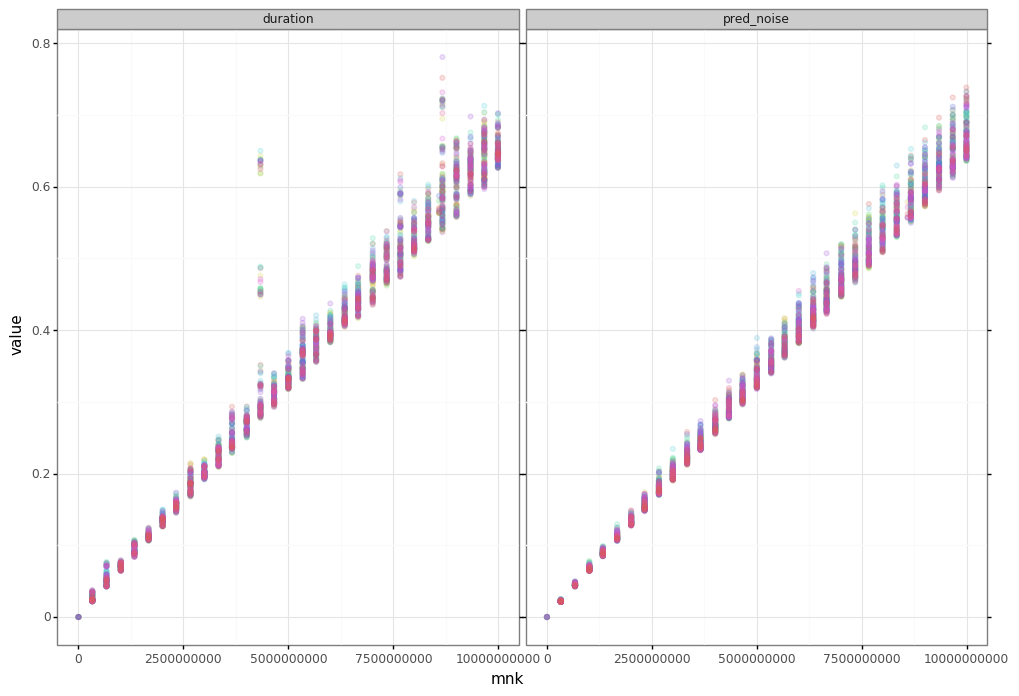

<ggplot: (-9223363288752742056)>


/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


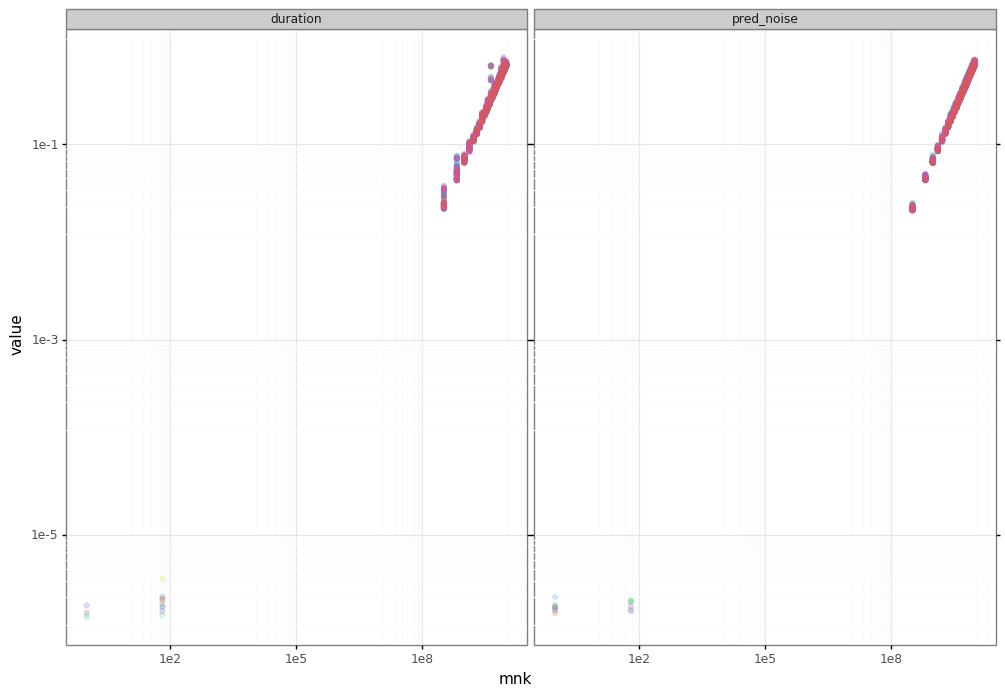

<ggplot: (8748076834182)>


In [14]:
plot = ggplot(tmp.sample(n=10000), aes(x='mnk', y='value', color='factor(cpu)')) + geom_point(alpha=0.2) + theme_bw() + facet_wrap('variable') + scale_color_discrete(guide=False)
print(plot)
print(plot + scale_x_log10() + scale_y_log10())

### Visualization (polynomial model)

In [15]:
compute_predictions(df, reg_local_poly, ['mnk', 'mn', 'mk', 'nk'])
df.head()

,function,m,n,k,timestamp,duration,core,node,cluster,jobid,...,mnk,mn,mk,nk,prediction,sd_noise,sigma,mu,noise,pred_noise
0,dgemm,6081,10182,140,199.910209,0.573353,0,1,dahu,1872787,...,8668343880,61916742,851340,1425480,0.593975,0.003565,0.005913,-0.004718,-0.003988,0.589987
1,dgemm,5658,1052,1288,200.483587,0.529990,0,1,dahu,1872787,...,7666454208,5952216,7287504,1354976,0.529159,0.003063,0.005081,-0.004054,0.004009,0.533169
2,dgemm,1139,4602,827,201.013586,0.304688,0,1,dahu,1872787,...,4334867706,5241678,941953,3805854,0.302638,0.001874,0.003109,-0.002480,0.009529,0.312167
3,dgemm,1343,1248,1991,201.318281,0.234120,0,1,dahu,1872787,...,3337043424,1676064,2673913,2484768,0.234982,0.001432,0.002375,-0.001895,0.000671,0.235653
4,dgemm,2466,975,1247,201.552409,0.209882,0,1,dahu,1872787,...,2998224450,2404350,3075102,1215825,0.209501,0.001240,0.002057,-0.001641,0.001388,0.210888


In [16]:
tmp = df.melt(id_vars=['cpu', 'node', 'mnk'], value_vars=['duration', 'pred_noise'])
tmp.head()

,cpu,node,mnk,variable,value
0,2,1,8668343880,duration,0.573353
1,2,1,7666454208,duration,0.529990
2,2,1,4334867706,duration,0.304688
3,2,1,3337043424,duration,0.234120
4,2,1,2998224450,duration,0.209882


/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


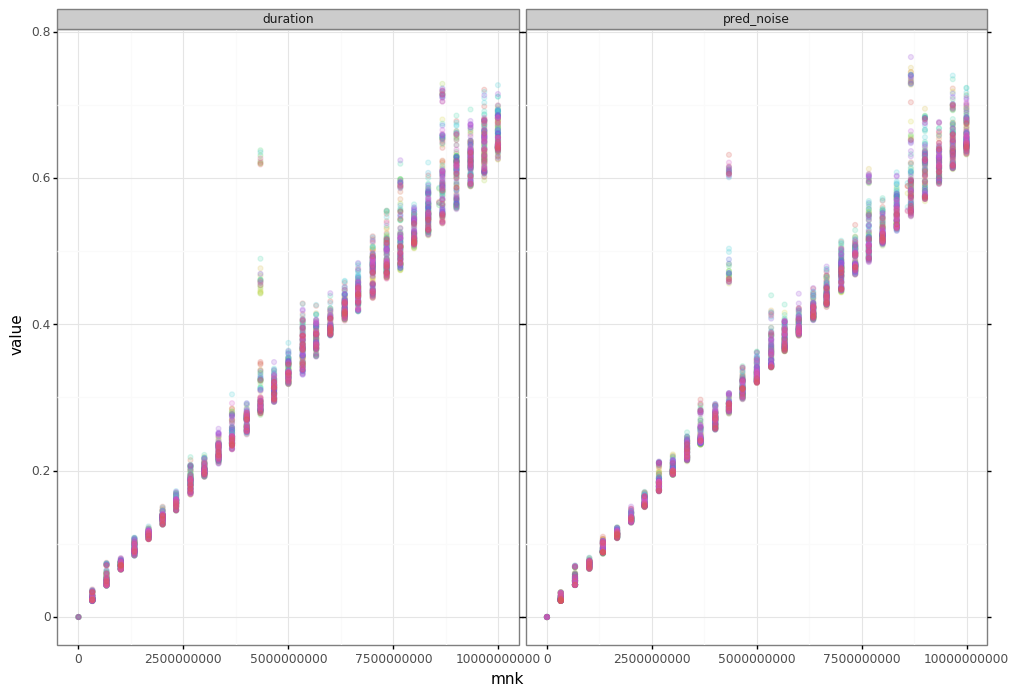

<ggplot: (-9223363288751455642)>


/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


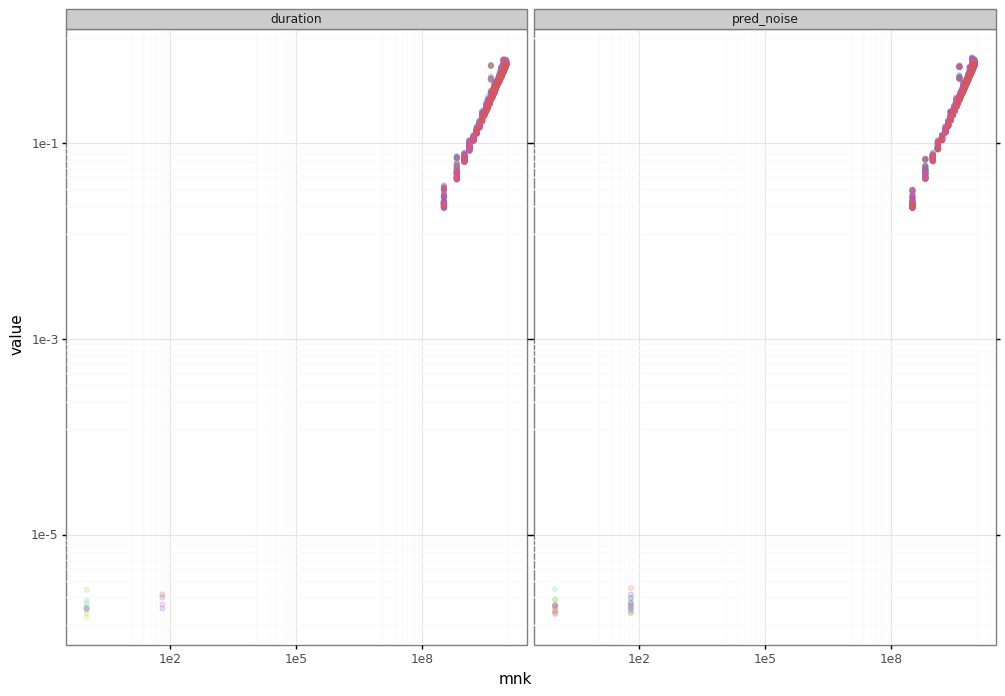

<ggplot: (8748072103986)>


In [17]:
plot = ggplot(tmp.sample(n=10000), aes(x='mnk', y='value', color='factor(cpu)')) + geom_point(alpha=0.2) + theme_bw() + facet_wrap('variable') + scale_color_discrete(guide=False)
print(plot)
print(plot + scale_x_log10() + scale_y_log10())

/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


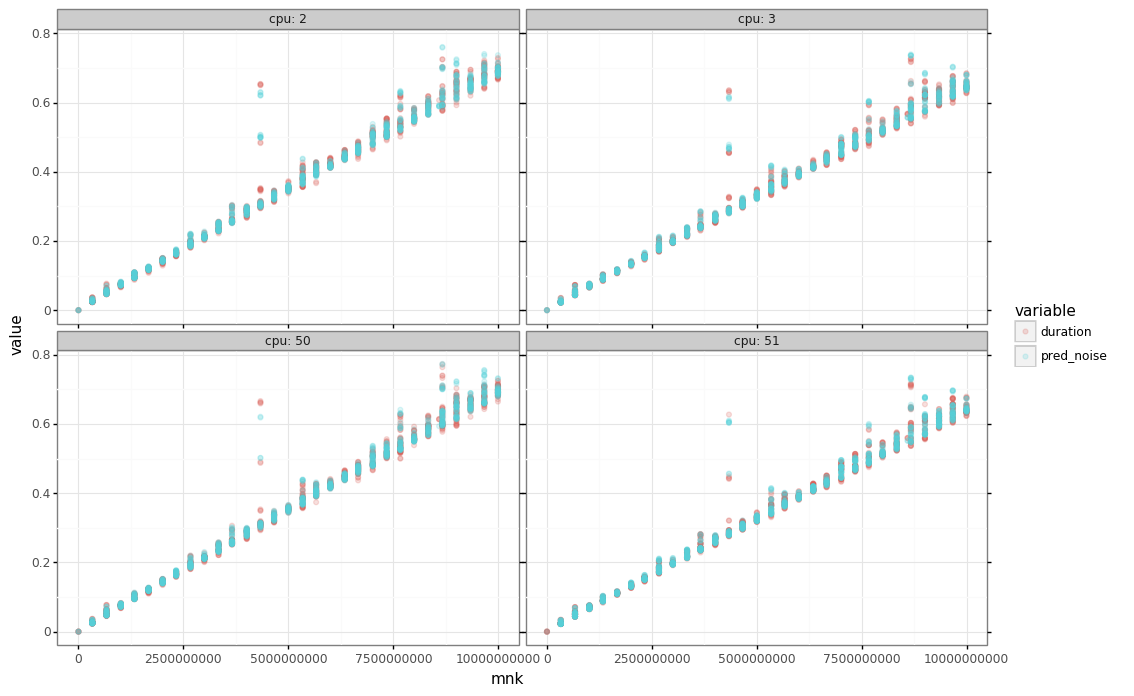

<ggplot: (8748072325885)>


/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


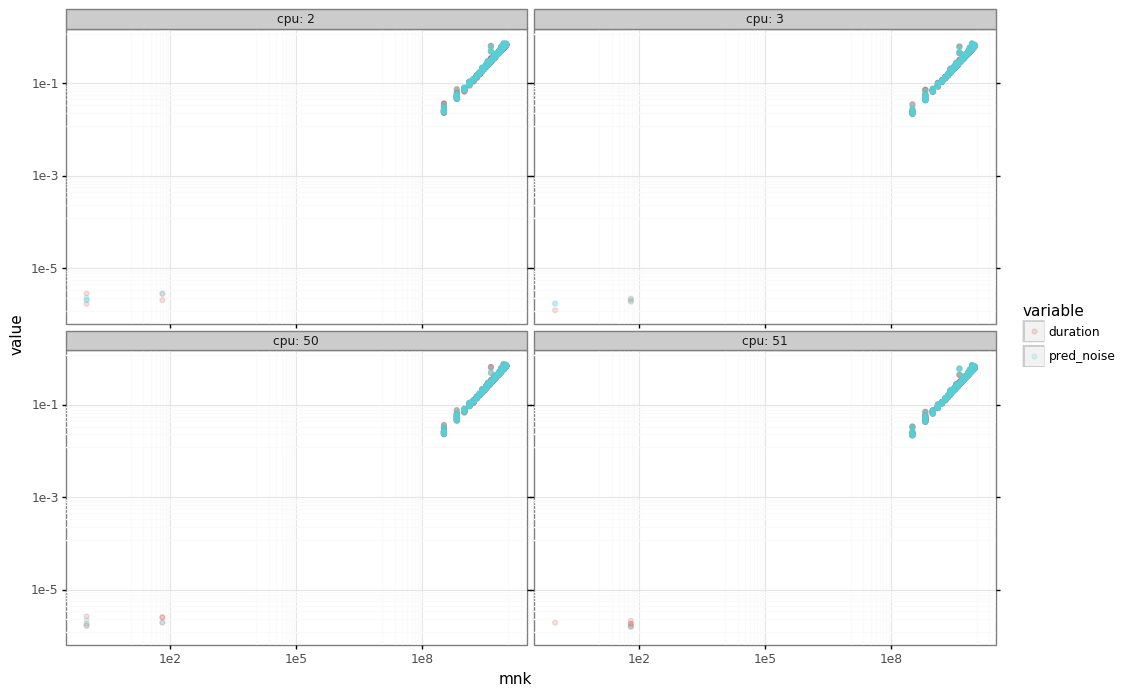

<ggplot: (-9223363288752690439)>


In [18]:
plot = ggplot(tmp[tmp.node.isin([1, 25])].sample(n=10000), aes(x='mnk', y='value', color='variable')) + geom_point(alpha=0.2) + theme_bw()
plot = plot + facet_wrap('cpu', labeller='label_both')
print(plot)
print(plot + scale_x_log10() + scale_y_log10())

### Validation of the polynomial model on HPL data

In [19]:
def read_csv(archive_name, csv_name, columns=None):
    archive = zipfile.ZipFile(archive_name)
    df= pandas.read_csv(io.BytesIO(archive.read(csv_name)), names=columns)
    df.columns = df.columns.str.strip()
    return df

hpl_archive = '../hpl/grenoble_2019-03-28_1856800.zip'
sizes = list(read_csv(hpl_archive, 'results.csv').matrix_size)

blas_col = ['file', 'line', 'function', 'rank', 'timestamp', 'duration', 'm', 'n', 'k']
hpl_dgemm = []
for i, size in enumerate(sizes):
    blas_trace = read_csv(hpl_archive, 'trace_blas_%d.csv' % i, columns=blas_col)
    blas_trace = blas_trace[(blas_trace['m'] != 0) & (blas_trace['n'] != 0) & (blas_trace['k'] != 0)]
    blas_trace['function'] = blas_trace['function'].str.strip()
    blas_trace = blas_trace[blas_trace['function'] == 'dgemm']
    hpl_dgemm.append(blas_trace)
hpl_dgemm = pandas.concat(hpl_dgemm)

df['origin'] = 'calibration'
hpl_dgemm['origin'] = 'HPL'
hpl_dgemm['size_product'] = hpl_dgemm.m * hpl_dgemm.n * hpl_dgemm.k

In [20]:
hpl_dgemm['mnk'] = hpl_dgemm.m * hpl_dgemm.n * hpl_dgemm.k
hpl_dgemm['mn'] = hpl_dgemm.m * hpl_dgemm.n
hpl_dgemm['mk'] = hpl_dgemm.m * hpl_dgemm.k
hpl_dgemm['nk'] = hpl_dgemm.n * hpl_dgemm.k

# The following supposes that HPL was executed on dahu-{1, 2, 3, ...} and that the ranks were mapped in order
hpl_dgemm['core'] = hpl_dgemm['rank']
hpl_dgemm['node'] = 1 + hpl_dgemm['rank'] // 32
hpl_dgemm['cpu'] = 2*hpl_dgemm['node'] + hpl_dgemm['core']%2

In [21]:
compute_predictions(hpl_dgemm, reg_local_poly, ['mnk', 'mn', 'mk', 'nk'])
hpl_dgemm.head()

,file,line,function,rank,timestamp,duration,m,n,k,origin,...,nk,core,node,cpu,prediction,sd_noise,sigma,mu,noise,pred_noise
13,../HPL_pdrpanrlT.c,224,dgemm,0,14.47309,0.000200,50046.0,2.0,2.0,HPL,...,4.0,0,1,2,0.000230,0.000002,0.000003,-0.000003,-1.740541e-06,0.000229
29,../HPL_pdrpanrlT.c,224,dgemm,0,14.47358,0.000380,50044.0,4.0,4.0,HPL,...,16.0,0,1,2,0.000485,0.000004,0.000006,-0.000005,-8.517476e-07,0.000484
43,../HPL_pdrpanrlT.c,224,dgemm,0,14.47421,0.000166,50042.0,2.0,2.0,HPL,...,4.0,0,1,2,0.000230,0.000002,0.000003,-0.000003,4.564754e-07,0.000231
66,../HPL_pdrpanrlT.c,224,dgemm,0,14.47468,0.000751,50040.0,8.0,8.0,HPL,...,64.0,0,1,2,0.001075,0.000008,0.000013,-0.000010,-9.933505e-06,0.001065
81,../HPL_pdrpanrlT.c,224,dgemm,0,14.47579,0.000177,50038.0,2.0,2.0,HPL,...,4.0,0,1,2,0.000230,0.000002,0.000003,-0.000003,8.559921e-07,0.000231


/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


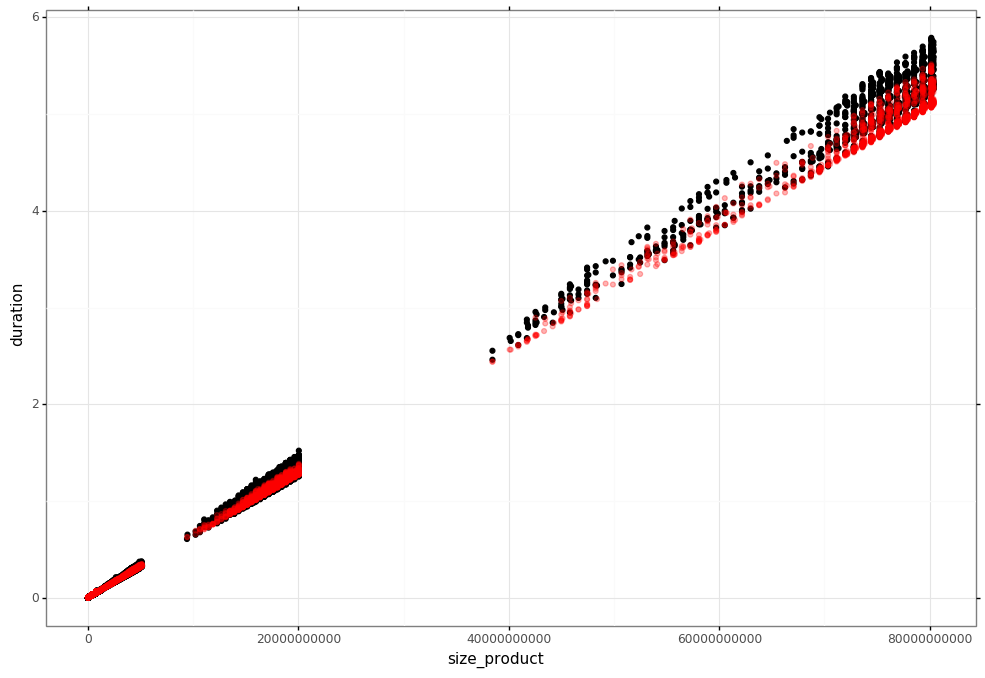

<ggplot: (-9223363288782722963)>


/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


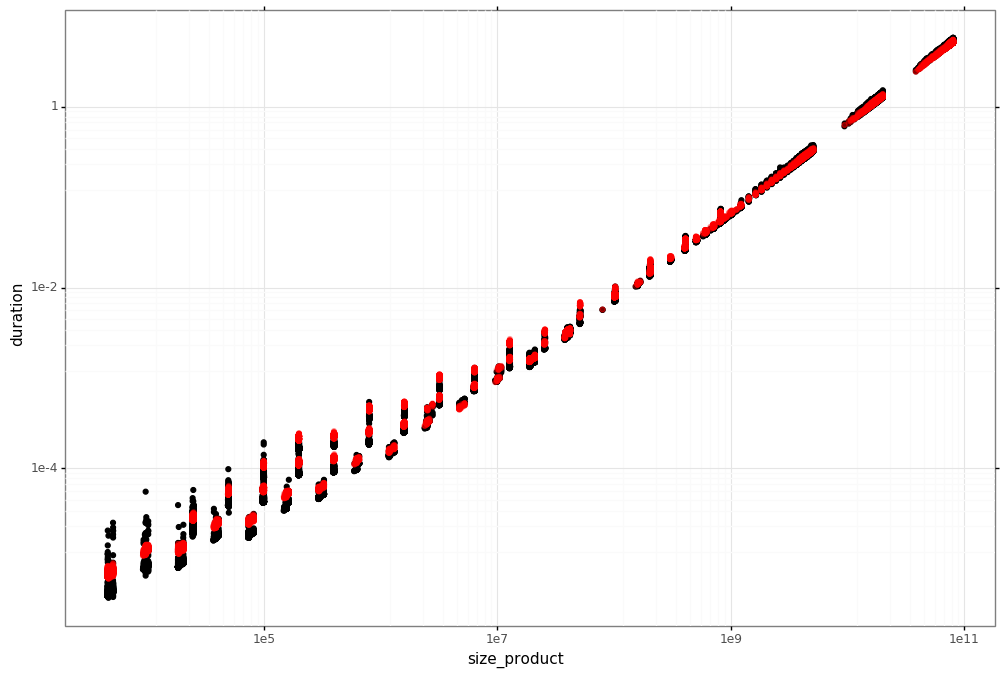

<ggplot: (8748103708557)>


In [22]:
plot = ggplot(hpl_dgemm) + geom_point(aes(x='size_product', y='duration')) + geom_point(aes(x='size_product', y='pred_noise'), color='red', alpha=0.3) + theme_bw()
print(plot)
print(plot + scale_x_log10() + scale_y_log10())

### Checking that the calibration data is reasonably close to HPL data

/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


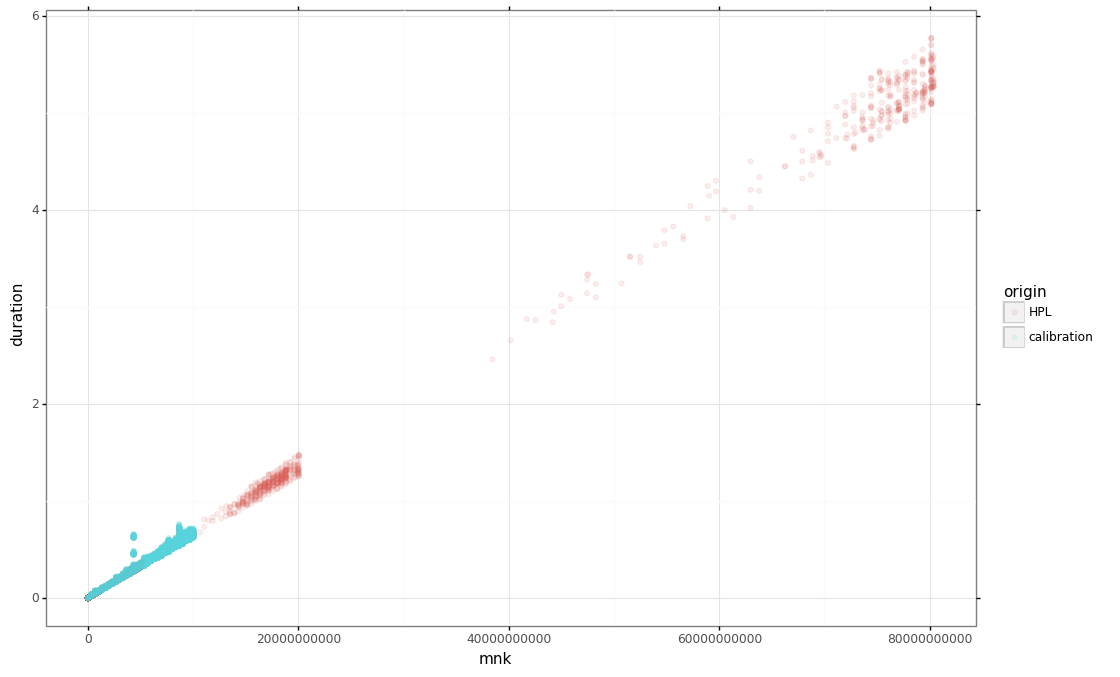

<ggplot: (8748077011148)>


/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/layer.py:449: UserWarning: geom_point : Removed 350 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


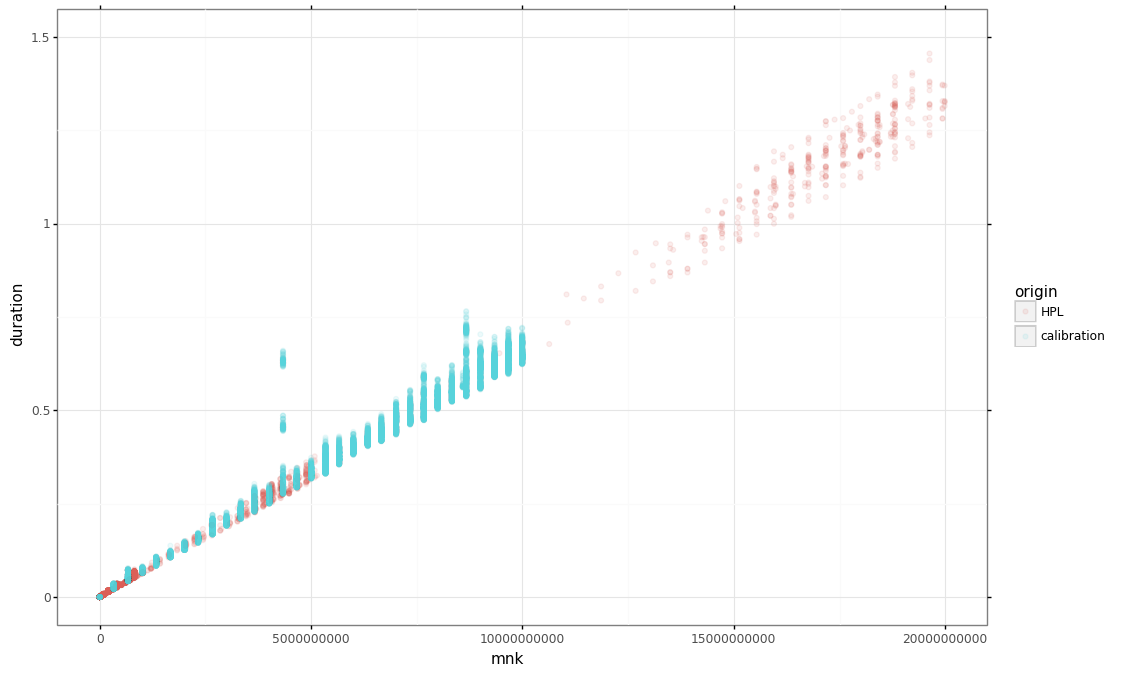

<ggplot: (8748103848775)>


/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


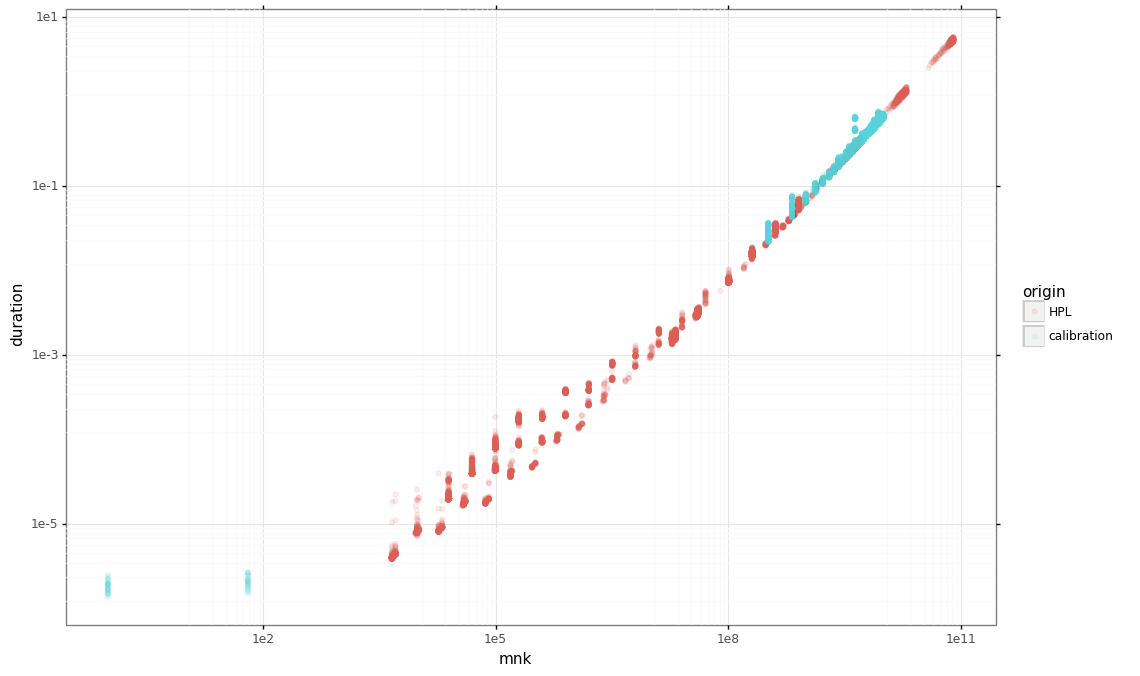

<ggplot: (8748102044038)>


In [23]:
df['origin'] = 'calibration'
hpl_dgemm['origin'] = 'HPL'
tmp = pandas.concat([hpl_dgemm.sample(n=20000), df.sample(n=20000)])
plot = ggplot(tmp) + geom_point(aes(x='mnk', y='duration', color='origin'), alpha=0.1) + theme_bw()
print(plot)
print(plot + xlim(0, 2e10) + ylim(0, 1.5))
print(plot + scale_x_log10() + scale_y_log10())

### Unbiasing the calibration (linear model)

We will only modify the `mnk` coefficient, so let's restrict ourselves to the largest sizes.

In [24]:
tmp = hpl_dgemm[hpl_dgemm.mnk > 1e10].copy()

To compute the bias factor, we compute the total **real** duration and the total **simulated** duration, then their ratio.

In [25]:
compute_predictions(tmp, reg_local, ['mnk'])
real_t = tmp.duration.sum()
pred_t = tmp.prediction.sum()
print('%.2f  |  %.2f' % (real_t, pred_t))
ratio_mnk = real_t / pred_t
ratio_mnk

7784.04  |  7802.17


0.9976755827547619

Now, let's keep the sizes that have been executed enough time (otherwise, `std` computation does not make much sense).

We will do the same thing than above, but with the mean of the standard deviations (grouped per size).

In [26]:
counts = tmp.groupby('mnk')[['m']].count().reset_index()
sizes = counts[counts.m > 30].mnk
print(len(sizes))
tmp = tmp[tmp.mnk.isin(sizes)]

28


In [27]:
real_std = tmp.groupby('mnk').duration.std().mean()
pred_std = tmp.groupby('mnk').pred_noise.std().mean()
print('%.2e  |  %.2e' % (real_std, pred_std))
ratio_mnk_residual = real_std / pred_std
ratio_mnk_residual

1.17e-01  |  1.23e-01


0.9519275403764625

Finally, we "unbias" the regression with those ratios.

In [28]:
for reg in reg_local:
    reg['mnk'] *= ratio_mnk
    reg['mnk_residual'] *= ratio_mnk_residual

Now, we draw the plot to validate our new model:

/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


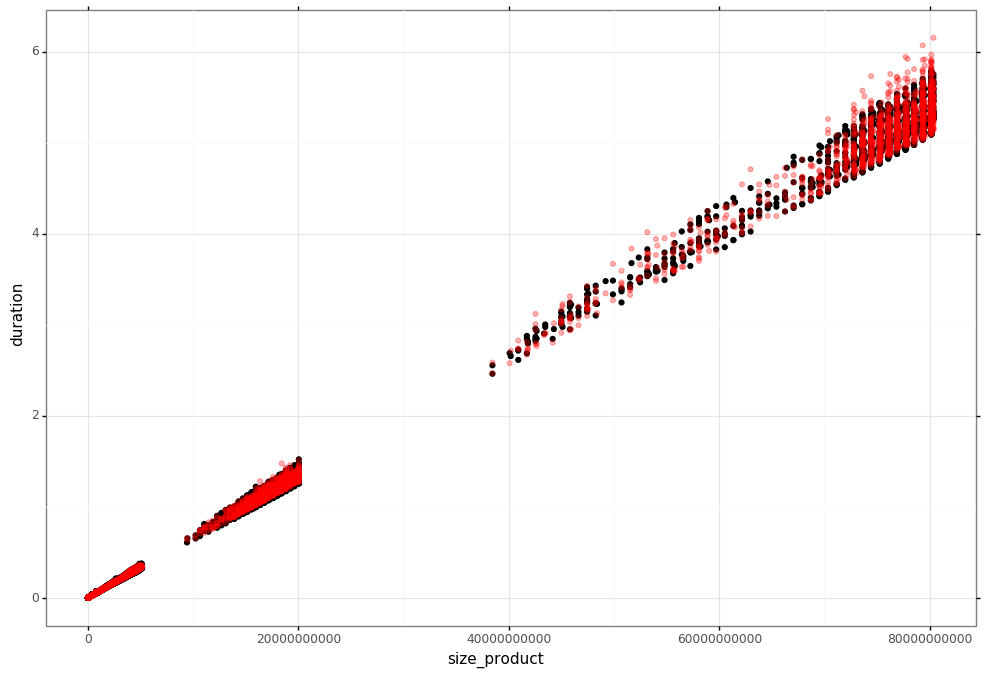

<ggplot: (-9223363288697604941)>


/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


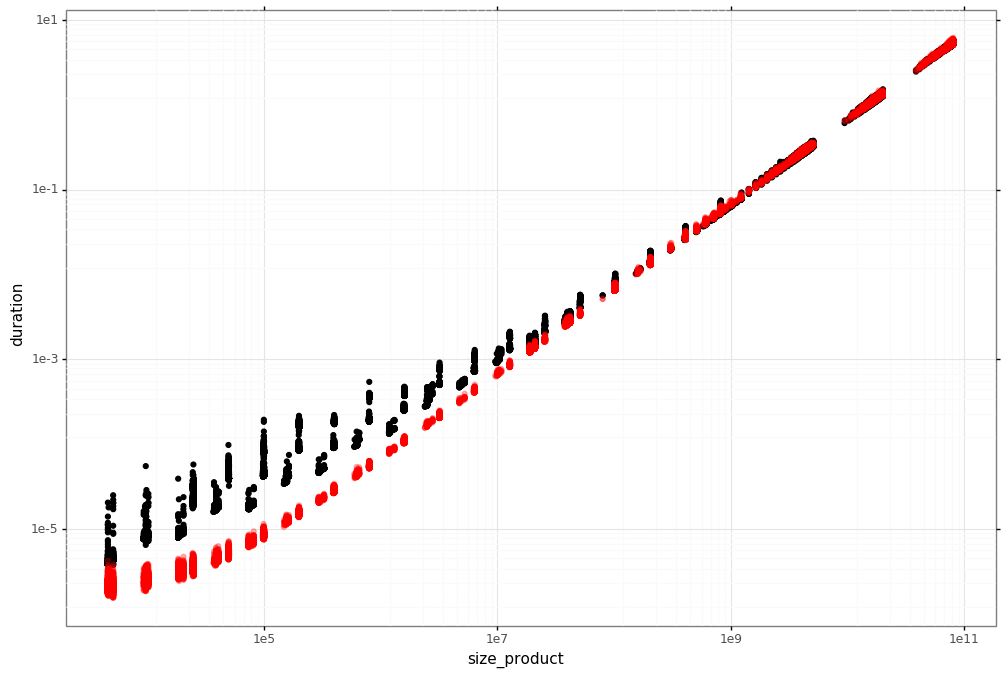

<ggplot: (8748103791792)>


In [29]:
compute_predictions(hpl_dgemm, reg_local, ['mnk'])
plot = ggplot(hpl_dgemm) + geom_point(aes(x='size_product', y='duration')) + geom_point(aes(x='size_product', y='pred_noise'), color='red', alpha=0.3) + theme_bw()
print(plot)
print(plot + scale_x_log10() + scale_y_log10())

And we dump the C code for this model:

In [30]:
dump_reg(reg_local)

```c
double mu, sigma;
switch(get_cpuid()) {
    case 2: // node 1
        mu    = 2.031875e-06 + 7.089503e-11*mnk;
        sigma = 3.568280e-07 + 2.146765e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 3: // node 1
        mu    = 1.823625e-06 + 6.665738e-11*mnk;
        sigma = 2.867134e-07 + 2.109864e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 4: // node 2
        mu    = 1.793563e-06 + 6.943151e-11*mnk;
        sigma = 2.294533e-07 + 2.192932e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 5: // node 2
        mu    = 2.039063e-06 + 6.656724e-11*mnk;
        sigma = 4.459159e-07 + 2.114460e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 6: // node 3
        mu    = 1.959375e-06 + 6.840299e-11*mnk;
        sigma = 2.402006e-07 + 2.192171e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 7: // node 3
        mu    = 1.847375e-06 + 6.642321e-11*mnk;
        sigma = 3.594620e-07 + 2.059016e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 8: // node 4
        mu    = 1.998187e-06 + 6.655238e-11*mnk;
        sigma = 3.049520e-07 + 2.071881e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 9: // node 4
        mu    = 1.817000e-06 + 6.660695e-11*mnk;
        sigma = 3.134492e-07 + 2.065467e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 10: // node 5
        mu    = 1.820687e-06 + 6.884917e-11*mnk;
        sigma = 2.678372e-07 + 2.163212e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 11: // node 5
        mu    = 1.947375e-06 + 6.618913e-11*mnk;
        sigma = 3.068313e-07 + 2.005688e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 12: // node 6
        mu    = 1.713125e-06 + 6.882313e-11*mnk;
        sigma = 3.035692e-07 + 2.159327e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 13: // node 6
        mu    = 1.699313e-06 + 6.595870e-11*mnk;
        sigma = 3.698865e-07 + 2.014535e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 14: // node 7
        mu    = 1.886312e-06 + 6.654638e-11*mnk;
        sigma = 2.518608e-07 + 2.090538e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 15: // node 7
        mu    = 1.796812e-06 + 6.604634e-11*mnk;
        sigma = 3.626939e-07 + 1.993063e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 16: // node 8
        mu    = 1.804438e-06 + 6.750281e-11*mnk;
        sigma = 2.663016e-07 + 2.111583e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 17: // node 8
        mu    = 1.838500e-06 + 6.629657e-11*mnk;
        sigma = 2.998226e-07 + 2.046241e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 18: // node 9
        mu    = 1.917312e-06 + 6.645334e-11*mnk;
        sigma = 3.490054e-07 + 2.026941e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 19: // node 9
        mu    = 1.847000e-06 + 6.630077e-11*mnk;
        sigma = 3.180082e-07 + 2.022967e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 20: // node 10
        mu    = 1.761937e-06 + 6.662196e-11*mnk;
        sigma = 2.238800e-07 + 2.087194e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 21: // node 10
        mu    = 1.922875e-06 + 6.661536e-11*mnk;
        sigma = 3.366890e-07 + 2.079113e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 22: // node 11
        mu    = 1.861937e-06 + 6.622357e-11*mnk;
        sigma = 4.185254e-07 + 2.031334e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 23: // node 11
        mu    = 2.156563e-06 + 6.751946e-11*mnk;
        sigma = 4.030012e-07 + 2.158426e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 24: // node 12
        mu    = 2.022250e-06 + 6.649450e-11*mnk;
        sigma = 2.922302e-07 + 2.064654e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 25: // node 12
        mu    = 1.895062e-06 + 6.622475e-11*mnk;
        sigma = 3.338113e-07 + 2.043099e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 26: // node 13
        mu    = 1.946938e-06 + 6.712666e-11*mnk;
        sigma = 2.636078e-07 + 2.126319e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 27: // node 13
        mu    = 1.915750e-06 + 6.640446e-11*mnk;
        sigma = 4.160324e-07 + 2.035143e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 28: // node 14
        mu    = 1.888000e-06 + 6.721964e-11*mnk;
        sigma = 3.060832e-07 + 2.146180e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 29: // node 14
        mu    = 1.876250e-06 + 6.640571e-11*mnk;
        sigma = 4.447404e-07 + 2.061288e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 30: // node 15
        mu    = 2.027313e-06 + 7.105527e-11*mnk;
        sigma = 3.439558e-07 + 2.162025e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 31: // node 15
        mu    = 1.897313e-06 + 6.629775e-11*mnk;
        sigma = 3.715223e-07 + 2.034065e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 32: // node 16
        mu    = 1.805000e-06 + 6.843961e-11*mnk;
        sigma = 1.983260e-07 + 2.140443e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 33: // node 16
        mu    = 2.061687e-06 + 6.650259e-11*mnk;
        sigma = 3.943524e-07 + 2.053045e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 34: // node 17
        mu    = 1.927125e-06 + 7.088907e-11*mnk;
        sigma = 2.357691e-07 + 2.149820e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 35: // node 17
        mu    = 1.840500e-06 + 6.662498e-11*mnk;
        sigma = 2.561754e-07 + 2.104414e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 36: // node 18
        mu    = 2.027813e-06 + 7.018252e-11*mnk;
        sigma = 3.002064e-07 + 2.134772e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 37: // node 18
        mu    = 1.824375e-06 + 6.630521e-11*mnk;
        sigma = 3.967755e-07 + 2.012848e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 38: // node 19
        mu    = 1.970375e-06 + 6.682882e-11*mnk;
        sigma = 2.644972e-07 + 2.120927e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 39: // node 19
        mu    = 2.141750e-06 + 6.639155e-11*mnk;
        sigma = 5.203626e-07 + 2.052522e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 40: // node 20
        mu    = 1.865688e-06 + 6.725642e-11*mnk;
        sigma = 2.772743e-07 + 2.117133e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 41: // node 20
        mu    = 1.844062e-06 + 6.635935e-11*mnk;
        sigma = 3.830493e-07 + 2.053453e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 42: // node 21
        mu    = 1.899687e-06 + 6.811646e-11*mnk;
        sigma = 2.948335e-07 + 2.168911e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 43: // node 21
        mu    = 1.940625e-06 + 6.656142e-11*mnk;
        sigma = 1.735386e-07 + 2.077141e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 44: // node 22
        mu    = 1.919000e-06 + 6.667892e-11*mnk;
        sigma = 2.798954e-07 + 2.096335e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 45: // node 22
        mu    = 1.875250e-06 + 6.687615e-11*mnk;
        sigma = 2.939988e-07 + 2.073643e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 46: // node 23
        mu    = 1.888875e-06 + 6.666754e-11*mnk;
        sigma = 3.385195e-07 + 2.090285e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 47: // node 23
        mu    = 1.901437e-06 + 6.605016e-11*mnk;
        sigma = 3.148678e-07 + 2.004616e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 48: // node 24
        mu    = 1.881375e-06 + 6.668186e-11*mnk;
        sigma = 2.714981e-07 + 2.086284e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 49: // node 24
        mu    = 2.094625e-06 + 6.627112e-11*mnk;
        sigma = 6.198059e-07 + 2.027162e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 50: // node 25
        mu    = 2.032188e-06 + 7.135967e-11*mnk;
        sigma = 3.254480e-07 + 2.154060e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 51: // node 25
        mu    = 1.833188e-06 + 6.599957e-11*mnk;
        sigma = 3.375893e-07 + 2.021207e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 52: // node 26
        mu    = 1.880250e-06 + 6.647706e-11*mnk;
        sigma = 2.736377e-07 + 2.051089e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 53: // node 26
        mu    = 1.970313e-06 + 6.691876e-11*mnk;
        sigma = 4.829437e-07 + 2.113398e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 54: // node 27
        mu    = 1.980687e-06 + 6.674318e-11*mnk;
        sigma = 2.983720e-07 + 2.099196e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 55: // node 27
        mu    = 1.974188e-06 + 6.686199e-11*mnk;
        sigma = 2.836010e-07 + 2.106967e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 56: // node 28
        mu    = 1.977875e-06 + 6.869802e-11*mnk;
        sigma = 2.558424e-07 + 2.147067e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 57: // node 28
        mu    = 1.857938e-06 + 6.630950e-11*mnk;
        sigma = 3.404247e-07 + 2.033643e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 58: // node 29
        mu    = 1.896375e-06 + 6.652144e-11*mnk;
        sigma = 2.431139e-07 + 2.075896e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 59: // node 29
        mu    = 1.762000e-06 + 6.649413e-11*mnk;
        sigma = 2.861419e-07 + 2.044431e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 60: // node 30
        mu    = 1.794250e-06 + 6.628271e-11*mnk;
        sigma = 3.752261e-07 + 2.032734e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 61: // node 30
        mu    = 1.848187e-06 + 6.613762e-11*mnk;
        sigma = 4.537737e-07 + 2.029401e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 62: // node 31
        mu    = 1.764000e-06 + 6.657323e-11*mnk;
        sigma = 2.465163e-07 + 2.050375e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 63: // node 31
        mu    = 1.943188e-06 + 6.653508e-11*mnk;
        sigma = 3.981035e-07 + 2.078539e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 64: // node 32
        mu    = 1.809313e-06 + 6.626337e-11*mnk;
        sigma = 3.340864e-07 + 2.032057e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 65: // node 32
        mu    = 1.880875e-06 + 6.621148e-11*mnk;
        sigma = 3.672168e-07 + 2.008040e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    default:
        mu    = 1.901050e-06 + 6.710598e-11*mnk;
        sigma = 3.266040e-07 + 2.082146e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
}
```

### Unbiasing the calibration (polynomial model)

We will only modify the `mnk` coefficient, so let's restrict ourselves to the largest sizes.

In [31]:
tmp = hpl_dgemm[hpl_dgemm.mnk > 1e10].copy()

To compute the bias factor, we compute the total **real** duration and the total **simulated** duration, then their ratio.

In [32]:
compute_predictions(tmp, reg_local_poly, ['mnk', 'mn', 'nk', 'mk'])
real_t = tmp.duration.sum()
pred_t = tmp.prediction.sum()
print('%.2f  |  %.2f' % (real_t, pred_t))
ratio_mnk = real_t / pred_t
ratio_mnk

7784.04  |  7477.57


1.0409846741048248

Now, let's keep the sizes that have been executed enough time (otherwise, `std` computation does not make much sense).

We will do the same thing than above, but with the mean of the standard deviations (grouped per size).

In [33]:
counts = tmp.groupby(['mnk', 'mn', 'mk', 'nk'])[['m']].count().reset_index()
sizes = counts[counts.m > 30].mnk
print(len(sizes))
tmp = tmp[tmp.mnk.isin(sizes)]

28


In [34]:
real_std = tmp.groupby('mnk').duration.std().mean()
pred_std = tmp.groupby('mnk').pred_noise.std().mean()
print('%.2e  |  %.2e' % (real_std, pred_std))
ratio_mnk_residual = real_std / pred_std
ratio_mnk_residual

1.17e-01  |  6.73e-02


1.7419871331639702

Finally, we "unbias" the regression with those ratios.

In [35]:
for reg in reg_local_poly:
    reg['mnk'] *= ratio_mnk
    reg['mnk_residual'] *= ratio_mnk_residual

Now, we draw the plot to validate our new model:

/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


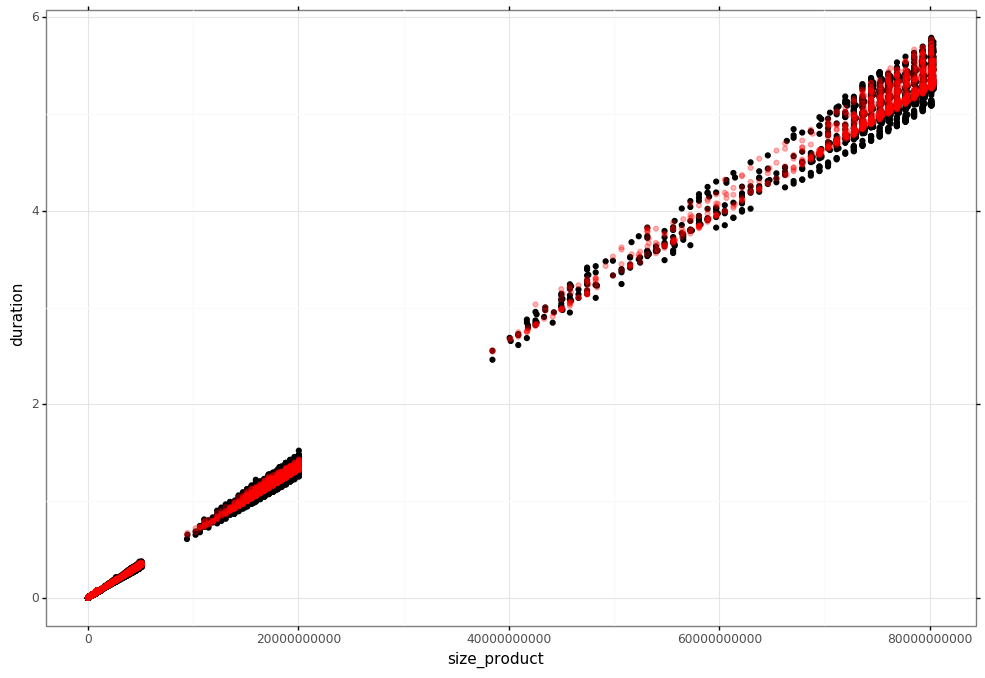

<ggplot: (-9223363288777837610)>


/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


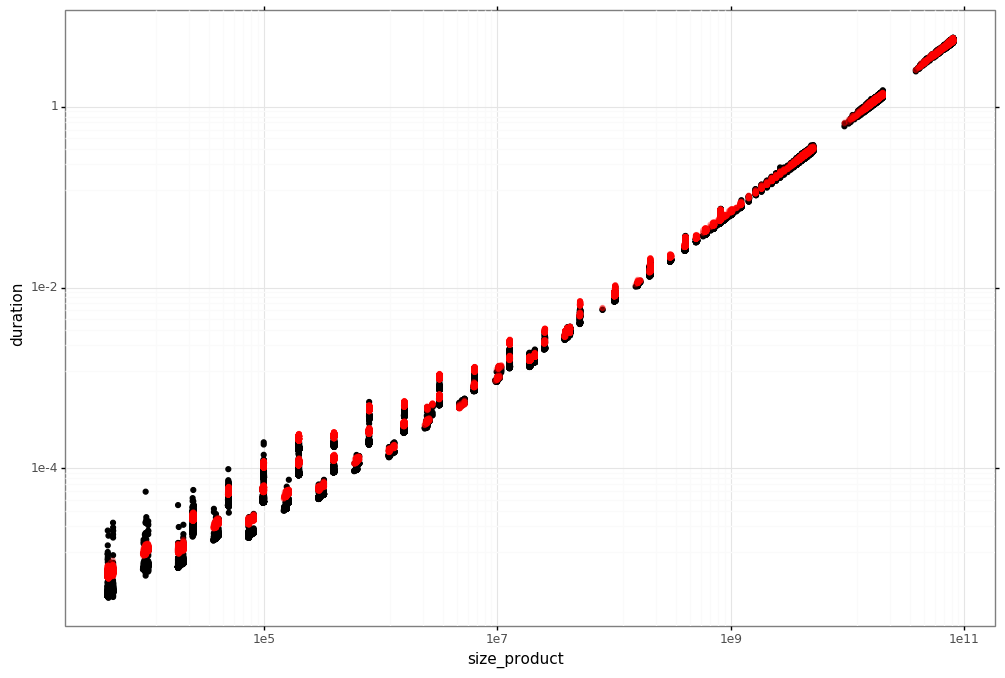

<ggplot: (8748076761022)>


In [36]:
compute_predictions(hpl_dgemm, reg_local_poly, ['mnk', 'mn', 'nk', 'mk'])
plot = ggplot(hpl_dgemm) + geom_point(aes(x='size_product', y='duration')) + geom_point(aes(x='size_product', y='pred_noise'), color='red', alpha=0.3) + theme_bw()
print(plot)
print(plot + scale_x_log10() + scale_y_log10())

And we dump the C code for this model:

In [37]:
dump_reg(reg_local_poly)

```c
double mu, sigma;
switch(get_cpuid()) {
    case 2: // node 1
        mu    = 2.031875e-06 + 6.919787e-11*mnk + 1.894452e-10*mn + 1.957824e-09*mk + 3.059798e-09*nk;
        sigma = 3.568280e-07 + 6.546626e-13*mnk + 3.490725e-12*mn + 1.151553e-11*mk + 5.660122e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 3: // node 1
        mu    = 1.823625e-06 + 6.479946e-11*mnk + 1.793597e-10*mn + 1.830960e-09*mk + 3.183051e-09*nk;
        sigma = 2.867134e-07 + 2.095819e-13*mnk + 5.485074e-12*mn + 3.488718e-11*mk + 3.129052e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 4: // node 2
        mu    = 1.793563e-06 + 6.774704e-11*mnk + 1.774582e-10*mn + 1.938141e-09*mk + 3.001103e-09*nk;
        sigma = 2.294533e-07 + 9.302963e-13*mnk + -1.058776e-12*mn + 1.914962e-11*mk + 4.256655e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 5: // node 2
        mu    = 2.039063e-06 + 6.470399e-11*mnk + 1.835837e-10*mn + 1.821377e-09*mk + 3.190992e-09*nk;
        sigma = 4.459159e-07 + 1.710315e-13*mnk + 1.579534e-11*mn + 2.760985e-11*mk + 3.029784e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 6: // node 3
        mu    = 1.959375e-06 + 6.661109e-11*mnk + 1.764182e-10*mn + 1.916735e-09*mk + 3.100890e-09*nk;
        sigma = 2.402006e-07 + 7.941621e-13*mnk + 1.217797e-12*mn + 1.612409e-11*mk + 1.541685e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 7: // node 3
        mu    = 1.847375e-06 + 6.463682e-11*mnk + 1.764626e-10*mn + 1.797731e-09*mk + 3.131726e-09*nk;
        sigma = 3.594620e-07 + 1.994159e-13*mnk + 1.555055e-12*mn + 2.090426e-11*mk + 2.464432e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 8: // node 4
        mu    = 1.998187e-06 + 6.474189e-11*mnk + 1.824372e-10*mn + 1.811525e-09*mk + 3.143610e-09*nk;
        sigma = 3.049520e-07 + 2.106099e-13*mnk + 8.917642e-12*mn + 2.398301e-11*mk + 2.528166e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 9: // node 4
        mu    = 1.817000e-06 + 6.481249e-11*mnk + 1.785609e-10*mn + 1.806540e-09*mk + 3.135141e-09*nk;
        sigma = 3.134492e-07 + 2.072184e-13*mnk + 8.829644e-13*mn + 2.808735e-11*mk + 2.638956e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 10: // node 5
        mu    = 1.820687e-06 + 6.705632e-11*mnk + 1.894869e-10*mn + 1.946019e-09*mk + 3.075501e-09*nk;
        sigma = 2.678372e-07 + 7.033274e-13*mnk + 4.570862e-12*mn + 3.233506e-11*mk + 3.230984e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 11: // node 5
        mu    = 1.947375e-06 + 6.448573e-11*mnk + 1.862013e-10*mn + 1.756690e-09*mk + 3.062519e-09*nk;
        sigma = 3.068313e-07 + 2.164357e-13*mnk + 4.195734e-12*mn + 2.529380e-11*mk + 2.894407e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 12: // node 6
        mu    = 1.713125e-06 + 6.708489e-11*mnk + 1.828127e-10*mn + 1.940450e-09*mk + 3.026592e-09*nk;
        sigma = 3.035692e-07 + 7.542549e-13*mnk + 3.441705e-12*mn + 1.852717e-11*mk + 3.062344e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 13: // node 6
        mu    = 1.699313e-06 + 6.420634e-11*mnk + 1.880559e-10*mn + 1.742905e-09*mk + 3.115455e-09*nk;
        sigma = 3.698865e-07 + 1.329991e-13*mnk + 1.889689e-12*mn + 2.289241e-11*mk + 2.447070e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 14: // node 7
        mu    = 1.886312e-06 + 6.468654e-11*mnk + 1.800674e-10*mn + 1.832612e-09*mk + 3.179120e-09*nk;
        sigma = 2.518608e-07 + 1.699576e-13*mnk + 3.179885e-12*mn + 2.565463e-11*mk + 3.214284e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 15: // node 7
        mu    = 1.796812e-06 + 6.435848e-11*mnk + 1.856477e-10*mn + 1.720842e-09*mk + 3.073904e-09*nk;
        sigma = 3.626939e-07 + 1.829955e-13*mnk + 2.203707e-12*mn + 1.879176e-11*mk + 2.035166e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 16: // node 8
        mu    = 1.804438e-06 + 6.569211e-11*mnk + 2.018187e-10*mn + 1.868968e-09*mk + 3.090713e-09*nk;
        sigma = 2.663016e-07 + 6.413282e-13*mnk + 6.523818e-12*mn + 2.301578e-11*mk + 3.021082e-12*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 17: // node 8
        mu    = 1.838500e-06 + 6.451100e-11*mnk + 1.848484e-10*mn + 1.782762e-09*mk + 3.130368e-09*nk;
        sigma = 2.998226e-07 + 1.838364e-13*mnk + 4.468914e-12*mn + 2.228399e-11*mk + 2.692329e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 18: // node 9
        mu    = 1.917312e-06 + 6.470338e-11*mnk + 1.846905e-10*mn + 1.788500e-09*mk + 3.091349e-09*nk;
        sigma = 3.490054e-07 + 1.821914e-13*mnk + 2.405213e-12*mn + 2.555409e-11*mk + 3.335459e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 19: // node 9
        mu    = 1.847000e-06 + 6.456668e-11*mnk + 1.829354e-10*mn + 1.775471e-09*mk + 3.084816e-09*nk;
        sigma = 3.180082e-07 + 1.891671e-13*mnk + 2.728627e-12*mn + 1.914810e-11*mk + 2.859961e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 20: // node 10
        mu    = 1.761937e-06 + 6.477195e-11*mnk + 1.855436e-10*mn + 1.821154e-09*mk + 3.179540e-09*nk;
        sigma = 2.238800e-07 + 1.737691e-13*mnk + 8.993402e-12*mn + 2.347787e-11*mk + 2.859278e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 21: // node 10
        mu    = 1.922875e-06 + 6.479865e-11*mnk + 1.770054e-10*mn + 1.813126e-09*mk + 3.159407e-09*nk;
        sigma = 3.366890e-07 + 1.816816e-13*mnk + 4.338806e-12*mn + 2.668150e-11*mk + 3.678854e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 22: // node 11
        mu    = 1.861937e-06 + 6.447836e-11*mnk + 1.815856e-10*mn + 1.771325e-09*mk + 3.098444e-09*nk;
        sigma = 4.185254e-07 + 1.938070e-13*mnk + 1.537229e-12*mn + 2.329886e-11*mk + 2.229895e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 23: // node 11
        mu    = 2.156563e-06 + 6.570887e-11*mnk + 1.694949e-10*mn + 1.898300e-09*mk + 3.101271e-09*nk;
        sigma = 4.030012e-07 + 6.282040e-13*mnk + 5.396304e-13*mn + 3.475840e-11*mk + 8.167141e-12*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 24: // node 12
        mu    = 2.022250e-06 + 6.469280e-11*mnk + 1.857814e-10*mn + 1.800993e-09*mk + 3.138911e-09*nk;
        sigma = 2.922302e-07 + 1.848088e-13*mnk + 8.117540e-12*mn + 2.387615e-11*mk + 2.887370e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 25: // node 12
        mu    = 1.895062e-06 + 6.447220e-11*mnk + 1.785727e-10*mn + 1.761633e-09*mk + 3.116495e-09*nk;
        sigma = 3.338113e-07 + 2.172739e-13*mnk + 4.419396e-12*mn + 2.463158e-11*mk + 2.695258e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 26: // node 13
        mu    = 1.946938e-06 + 6.525883e-11*mnk + 1.877887e-10*mn + 1.868990e-09*mk + 3.163174e-09*nk;
        sigma = 2.636078e-07 + 4.638386e-13*mnk + 6.017135e-12*mn + 3.442548e-11*mk + 6.810535e-12*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 27: // node 13
        mu    = 1.915750e-06 + 6.461585e-11*mnk + 1.910115e-10*mn + 1.802216e-09*mk + 3.116125e-09*nk;
        sigma = 4.160324e-07 + 1.383615e-13*mnk + 6.492119e-12*mn + 2.946518e-11*mk + 3.494893e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 28: // node 14
        mu    = 1.888000e-06 + 6.537768e-11*mnk + 1.864690e-10*mn + 1.875896e-09*mk + 3.131536e-09*nk;
        sigma = 3.060832e-07 + 5.750957e-13*mnk + 3.680653e-12*mn + 2.101870e-11*mk + -1.092789e-12*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 29: // node 14
        mu    = 1.876250e-06 + 6.461061e-11*mnk + 1.820832e-10*mn + 1.808254e-09*mk + 3.121687e-09*nk;
        sigma = 4.447404e-07 + 1.892946e-13*mnk + 3.545912e-12*mn + 3.104860e-11*mk + 2.832664e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 30: // node 15
        mu    = 2.027313e-06 + 6.929758e-11*mnk + 1.922304e-10*mn + 1.948290e-09*mk + 3.141456e-09*nk;
        sigma = 3.439558e-07 + 5.432291e-13*mnk + -5.454007e-13*mn + 2.034084e-11*mk + 5.456848e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 31: // node 15
        mu    = 1.897313e-06 + 6.453426e-11*mnk + 1.843830e-10*mn + 1.780865e-09*mk + 3.107970e-09*nk;
        sigma = 3.715223e-07 + 1.996895e-13*mnk + 2.746758e-12*mn + 3.419336e-11*mk + 2.789535e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 32: // node 16
        mu    = 1.805000e-06 + 6.668373e-11*mnk + 1.963515e-10*mn + 1.902175e-09*mk + 3.055625e-09*nk;
        sigma = 1.983260e-07 + 7.795085e-13*mnk + -1.877178e-13*mn + 1.898083e-11*mk + 2.763580e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 33: // node 16
        mu    = 2.061687e-06 + 6.471312e-11*mnk + 1.845531e-10*mn + 1.828339e-09*mk + 3.097299e-09*nk;
        sigma = 3.943524e-07 + 2.342175e-13*mnk + 1.423471e-12*mn + 3.001454e-11*mk + 2.359264e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 34: // node 17
        mu    = 1.927125e-06 + 6.918716e-11*mnk + 1.856543e-10*mn + 1.951536e-09*mk + 3.074791e-09*nk;
        sigma = 2.357691e-07 + 6.183317e-13*mnk + -1.695110e-12*mn + 9.921222e-12*mk + 5.907562e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 35: // node 17
        mu    = 1.840500e-06 + 6.475463e-11*mnk + 1.927742e-10*mn + 1.831524e-09*mk + 3.180327e-09*nk;
        sigma = 2.561754e-07 + 2.190658e-13*mnk + 2.123358e-11*mn + 3.975663e-11*mk + 3.633289e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 36: // node 18
        mu    = 2.027813e-06 + 6.846164e-11*mnk + 1.897923e-10*mn + 1.946888e-09*mk + 3.061945e-09*nk;
        sigma = 3.002064e-07 + 6.535486e-13*mnk + 1.534159e-12*mn + 2.021704e-11*mk + 4.761329e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 37: // node 18
        mu    = 1.824375e-06 + 6.456765e-11*mnk + 1.900092e-10*mn + 1.774452e-09*mk + 3.080977e-09*nk;
        sigma = 3.967755e-07 + 1.613003e-13*mnk + 7.973807e-12*mn + 3.017221e-11*mk + 3.535747e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 38: // node 19
        mu    = 1.970375e-06 + 6.494850e-11*mnk + 1.920121e-10*mn + 1.865684e-09*mk + 3.167318e-09*nk;
        sigma = 2.644972e-07 + 3.289898e-13*mnk + 3.262568e-12*mn + 3.674321e-11*mk + 2.242468e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 39: // node 19
        mu    = 2.141750e-06 + 6.461223e-11*mnk + 1.806515e-10*mn + 1.815777e-09*mk + 3.100431e-09*nk;
        sigma = 5.203626e-07 + 1.694313e-13*mnk + 5.948582e-12*mn + 2.917513e-11*mk + 3.102934e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 40: // node 20
        mu    = 1.865688e-06 + 6.545990e-11*mnk + 1.775456e-10*mn + 1.873070e-09*mk + 3.093043e-09*nk;
        sigma = 2.772743e-07 + 5.494137e-13*mnk + 3.727996e-12*mn + 2.842684e-11*mk + 3.715435e-12*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 41: // node 20
        mu    = 1.844062e-06 + 6.457189e-11*mnk + 1.765124e-10*mn + 1.793335e-09*mk + 3.132016e-09*nk;
        sigma = 3.830493e-07 + 2.143595e-13*mnk + -5.900886e-13*mn + 2.196805e-11*mk + 2.230576e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 42: // node 21
        mu    = 1.899687e-06 + 6.633246e-11*mnk + 1.823384e-10*mn + 1.934606e-09*mk + 3.045230e-09*nk;
        sigma = 2.948335e-07 + 7.421231e-13*mnk + 3.267378e-12*mn + 1.649370e-11*mk + 3.111276e-12*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 43: // node 21
        mu    = 1.940625e-06 + 6.475003e-11*mnk + 1.823388e-10*mn + 1.810218e-09*mk + 3.145768e-09*nk;
        sigma = 1.735386e-07 + 1.882534e-13*mnk + 6.707123e-12*mn + 2.474575e-11*mk + 3.197115e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 44: // node 22
        mu    = 1.919000e-06 + 6.483385e-11*mnk + 1.807678e-10*mn + 1.830860e-09*mk + 3.168339e-09*nk;
        sigma = 2.798954e-07 + 2.693333e-13*mnk + 5.173278e-12*mn + 3.026642e-11*mk + 2.443786e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 45: // node 22
        mu    = 1.875250e-06 + 6.506807e-11*mnk + 1.851101e-10*mn + 1.817828e-09*mk + 3.148130e-09*nk;
        sigma = 2.939988e-07 + 2.578584e-13*mnk + 1.082036e-11*mn + 2.882633e-11*mk + 2.512614e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 46: // node 23
        mu    = 1.888875e-06 + 6.480356e-11*mnk + 1.900429e-10*mn + 1.840601e-09*mk + 3.170487e-09*nk;
        sigma = 3.385195e-07 + 2.459952e-13*mnk + 3.035029e-12*mn + 2.264050e-11*mk + 2.355389e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 47: // node 23
        mu    = 1.901437e-06 + 6.434747e-11*mnk + 1.830547e-10*mn + 1.746030e-09*mk + 3.068161e-09*nk;
        sigma = 3.148678e-07 + 1.557446e-13*mnk + 6.254224e-12*mn + 2.339877e-11*mk + 3.333573e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 48: // node 24
        mu    = 1.881375e-06 + 6.485936e-11*mnk + 1.847761e-10*mn + 1.815567e-09*mk + 3.157869e-09*nk;
        sigma = 2.714981e-07 + 2.016489e-13*mnk + 1.018895e-11*mn + 3.048033e-11*mk + 2.878991e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 49: // node 24
        mu    = 2.094625e-06 + 6.454334e-11*mnk + 1.819293e-10*mn + 1.771843e-09*mk + 3.082092e-09*nk;
        sigma = 6.198059e-07 + 1.362692e-13*mnk + 7.659468e-12*mn + 2.986360e-11*mk + 3.252807e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 50: // node 25
        mu    = 2.032188e-06 + 6.961552e-11*mnk + 2.129481e-10*mn + 1.960147e-09*mk + 3.104120e-09*nk;
        sigma = 3.254480e-07 + 6.309041e-13*mnk + 2.279188e-12*mn + 1.972113e-11*mk + 5.946323e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 51: // node 25
        mu    = 1.833188e-06 + 6.424904e-11*mnk + 1.879407e-10*mn + 1.734425e-09*mk + 3.124894e-09*nk;
        sigma = 3.375893e-07 + 1.355014e-13*mnk + 5.629758e-12*mn + 2.100043e-11*mk + 2.561372e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 52: // node 26
        mu    = 1.880250e-06 + 6.467900e-11*mnk + 1.861967e-10*mn + 1.818913e-09*mk + 3.112147e-09*nk;
        sigma = 2.736377e-07 + 2.074884e-13*mnk + 6.304114e-12*mn + 2.695679e-11*mk + 2.317838e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 53: // node 26
        mu    = 1.970313e-06 + 6.504954e-11*mnk + 1.947658e-10*mn + 1.858818e-09*mk + 3.161671e-09*nk;
        sigma = 4.829437e-07 + 4.090640e-13*mnk + 6.153819e-12*mn + 3.070785e-11*mk + 4.566329e-12*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 54: // node 27
        mu    = 1.980687e-06 + 6.489013e-11*mnk + 1.833492e-10*mn + 1.859267e-09*mk + 3.144332e-09*nk;
        sigma = 2.983720e-07 + 3.012809e-13*mnk + 9.325486e-12*mn + 3.245553e-11*mk + 1.813336e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 55: // node 27
        mu    = 1.974188e-06 + 6.503106e-11*mnk + 1.845489e-10*mn + 1.865478e-09*mk + 3.117690e-09*nk;
        sigma = 2.836010e-07 + 4.342045e-13*mnk + 9.958234e-12*mn + 3.340051e-11*mk + 1.455744e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 56: // node 28
        mu    = 1.977875e-06 + 6.695951e-11*mnk + 1.957752e-10*mn + 1.899119e-09*mk + 3.049061e-09*nk;
        sigma = 2.558424e-07 + 7.509952e-13*mnk + -3.574783e-12*mn + 1.404136e-11*mk + 1.629091e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 57: // node 28
        mu    = 1.857938e-06 + 6.454369e-11*mnk + 1.840635e-10*mn + 1.772487e-09*mk + 3.118998e-09*nk;
        sigma = 3.404247e-07 + 1.500717e-13*mnk + 5.969057e-12*mn + 2.903712e-11*mk + 3.406740e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 58: // node 29
        mu    = 1.896375e-06 + 6.469370e-11*mnk + 1.817856e-10*mn + 1.812727e-09*mk + 3.160018e-09*nk;
        sigma = 2.431139e-07 + 1.937044e-13*mnk + 4.741775e-12*mn + 2.678295e-11*mk + 2.371321e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 59: // node 29
        mu    = 1.762000e-06 + 6.473257e-11*mnk + 1.839720e-10*mn + 1.780512e-09*mk + 3.115920e-09*nk;
        sigma = 2.861419e-07 + 1.747565e-13*mnk + 7.637732e-12*mn + 2.585554e-11*mk + 2.696759e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 60: // node 30
        mu    = 1.794250e-06 + 6.454037e-11*mnk + 1.836723e-10*mn + 1.785702e-09*mk + 3.081991e-09*nk;
        sigma = 3.752261e-07 + 2.282857e-13*mnk + 7.378904e-12*mn + 3.325473e-11*mk + 2.647763e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 61: // node 30
        mu    = 1.848187e-06 + 6.441980e-11*mnk + 1.813596e-10*mn + 1.757265e-09*mk + 3.074501e-09*nk;
        sigma = 4.537737e-07 + 2.015059e-13*mnk + 2.786832e-14*mn + 2.290080e-11*mk + 2.853973e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 62: // node 31
        mu    = 1.764000e-06 + 6.480890e-11*mnk + 1.824950e-10*mn + 1.770882e-09*mk + 3.135694e-09*nk;
        sigma = 2.465163e-07 + 2.162590e-13*mnk + 7.407017e-12*mn + 2.312908e-11*mk + 3.363025e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 63: // node 31
        mu    = 1.943188e-06 + 6.471888e-11*mnk + 1.846575e-10*mn + 1.794906e-09*mk + 3.165110e-09*nk;
        sigma = 3.981035e-07 + 2.650383e-13*mnk + 8.325095e-12*mn + 2.837281e-11*mk + 2.706379e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 64: // node 32
        mu    = 1.809313e-06 + 6.456844e-11*mnk + 1.788395e-10*mn + 1.740258e-09*mk + 3.081749e-09*nk;
        sigma = 3.340864e-07 + 1.869923e-13*mnk + 5.135284e-12*mn + 2.212050e-11*mk + 2.931581e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 65: // node 32
        mu    = 1.880875e-06 + 6.450284e-11*mnk + 1.834250e-10*mn + 1.777955e-09*mk + 3.049778e-09*nk;
        sigma = 3.672168e-07 + 1.827344e-13*mnk + 7.442627e-12*mn + 2.936419e-11*mk + 2.450741e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    default:
        mu    = 1.901050e-06 + 1.830098e-09*mk + 1.849726e-10*mn + 6.532377e-11*mnk + 3.113753e-09*nk;
        sigma = 3.266040e-07 + 2.553385e-11*mk + 4.807115e-12*mn + 3.315110e-13*mnk + 2.725599e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
}
```

### Dumping to a CSV file

In [39]:
compute_predictions(df, reg_local_poly, ['mnk', 'mn', 'nk', 'mk'])
df[['function', 'm', 'n', 'k', 'timestamp', 'duration', 'prediction', 'noise', 'pred_noise', 'node', 'core', 'cpu', 'index']].to_csv('/tmp/dgemm_calibration.csv', index=False)